<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2022/blob/prac-bayesian-deep-learning/Bayesian_Deep_Learning_Prac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Deep Learning Practical

<img src="https://i.imgur.com/btStvUL.png" width="90%" />



<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2022/blob/prac-bayesian-deep-learning/Bayesian_Deep_Learning_Prac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

© Deep Learning Indaba 2022. Apache License 2.0.

**Authors:**

Javier Antorán, James Allingham.

**Reviewers:**

Kale-ab Tessera

**Introduction:** 

Bayesian inference provides us with the tools to update our beliefs consistently when we observe data. Compared to the, more common, loss minimisation approach to learning, Bayesian methods offer us **calibrated uncertainty estimates**, **resistance to overfitting**, and even approaches to **select hyper-parameters without a validation set**. 🚀In this prac we will learn to do all of these things!🚀



**Aims/Learning Objectives:**


* Understand the tradeoffs of Maximum Likelihood vs fully Bayesian learning **[Sections 0 and 1]**
* Implement Bayesian linear regression **[Section 1]**
* Understand the challenges of Bayesian inference in non-conjugate models and the need for approximate inference **[Section 2]**
* Implement “black box” variational inference **[Section 3]**
* Understand the tradeoffs of different methods for approximate Bayesian Inference, e.g. variational inference vs Monte Carlo methods **[Sections 4 and 5]**

**Prerequisites:**

* Familiarity with Jax
* Basic Linear Algebra
* Basics of Bayesian inference [here is a 15 min video on the topic](https://www.youtube.com/watch?v=HZGCoVF3YvM) and / or Bayesian Inference parallel talk from the Indaba
* Recommended: Attend the Monte Carlo 101 parallel.



**Topics:** 

Content: 


0. [Warmup - Standard Linear Regression](#S0) 
1. [From Regression to Bayesian Linear Regression](#S1) 
2. [Logistic Regression & the Need for Approximate Inference](#S2) 
3. [Black Box Variational Inference](#S3) 
4. [Bayesian Neural Networks](#S4) 
5. [Hamiltonian Monte Carlo (Optional)](#S5) 



####
**Before you start:**

For this practical, you dont need any fancy computers. We are working smarter not harder! Set your runtime to CPU to get a guaranteed fast runtime allocation.

This prac contains excercises and sections at multiple levels of difficulty. These are labelled  <font color='green'>`Base`</font>,
 <font color='orange'>`Intermediate`</font> and
 <font color='red'>`Advanced`</font>. Only the <font color='green'>`Base`</font> exercises are part of the core prac. Non-core sections, for instance all of the <font color='red'>`Advanced`</font> ones, are labelled (Optional). If you do not have experience working with matrix calculus or probability disrtibutions, it is best to skip optional sections to ensure you reach the end of the prac.

This prac has a lot of content so if you get stuck it is best to ask a neighbour or tutor for help fast. After every code segment, there are a list of questions for you to answer. You are not expected to know the correct answer to all of these and your responses are not recorded anywhere. The questions are just there to get you thinking about the topic and discussing with others. Dont spend too much time on any single set of questions!


## Installation and Imports

In [111]:
%%capture
## Install and import anything required. Capture hides the output from the cell. 
#@title Install and import required packages. (Run Cell)

import os 

# https://stackoverflow.com/questions/68340858/in-google-colab-is-there-a-programing-way-to-check-which-runtime-like-gpu-or-tpu
if int(os.environ["COLAB_GPU"]) > 0:
  print("a GPU is connected.")
elif "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
  print("A TPU is connected.")
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
else:
  print("Only CPU accelerator is connected.")
  # x8 cpu devices - number of (emulated) host devices
  os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

!pip install optax
!pip install livelossplot 
!pip install numpyro

import jax
import jax.numpy as jnp
from jax.numpy.linalg import inv
from jax import grad, jit, vmap, random, value_and_grad
from jax.scipy.stats import norm, bernoulli
from jax.nn import sigmoid, tanh
from jax.nn.initializers import normal
from jax.scipy.linalg import solve


import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np

from functools import partial

import optax
from optax import sigmoid_binary_cross_entropy


from livelossplot import PlotLosses




In [2]:
#@title Helper Functions. (Run Cell)
#@markdown You dont need to change these throughout the practical.
#@markdown But take a look if you are curious! 🐈

import copy
from typing import Dict 

def plot_performance(data:Dict, title: str):
  runs = list(data.keys())
  time = list(data.values())
  
  # creating the bar plot
  plt.bar(runs, time, width = 0.35)
  
  plt.xlabel("Implementation")
  plt.ylabel("Average time taken (in s)")
  plt.title(title)
  plt.show()

  best_perf_key = min(data, key=data.get)
  all_runs_key = copy.copy(runs)

  # all_runs_key_except_best
  all_runs_key.remove(best_perf_key)

  for k in all_runs_key:
    print(f"{best_perf_key} was {round((data[k]/data[best_perf_key]),2)} times faster than {k} !!!")


def errorfill(x, y, yerr, color=None, alpha_fill=0.3, line_alpha=1, ax=None,
              lw=1, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label=None, markevery=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    plt_return = ax.plot(x, y, color=color, lw=lw, linestyle=linestyle, alpha=line_alpha, label=label, marker=marker, markersize=markersize, markevery=markevery)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill, linewidths=fill_linewidths)
    return plt_return
    
def plot_basic_data(x_data, y_data, parameters_list=None, title="Observed data", ylim=None):
  xlim = [jnp.min(x_data)-1, jnp.max(x_data)+1]
  
  if ylim is None:
    ylim = [jnp.min(y_data)-1, jnp.max(y_data)+1]
  fig, ax = plt.subplots()

  if parameters_list is not None:
    x_pred = np.linspace(xlim[0], xlim[1], 100)
    for parameters in parameters_list:
      y_pred = parameters[0] + parameters[1] * x_pred
      ax.plot(x_pred, y_pred, ':', color=[1, 0.7, 0.6])

    parameters = parameters_list[-1]
    y_pred = parameters[0] + parameters[1] * x_pred
    ax.plot(x_pred, y_pred, "-", color=[1, 0, 0], lw=2)

  ax.plot(x_data, y_data, "ob")
  ax.set(xlabel="Input x", ylabel="Output y",
         title=title,
         xlim=xlim, ylim=ylim)
  ax.grid()


def optimise(objective, params, plotting_func, LR, MAX_STEPS, LOG_EVERY):

  optimiser = optax.chain(
    optax.adam(LR, b1=0.99, b2=0.999)
  )
  opt_state = optimiser.init(params)

  def gen_update(objective):
    def update(params, opt_state, key):
      # get data neded for training
      value, grads = jax.value_and_grad(objective)(params, key)
      grads = jax.tree_map(lambda x: -x, grads)
      updates, opt_state = optimiser.update(grads, opt_state)
      params = optax.apply_updates(params, updates)
      return value, params, opt_state
  
    return jit(update)

  update = gen_update(objective)

  plotlosses = PlotLosses()
  objective_values = []
  artist_list = []

  key = random.PRNGKey(42)
  keys = random.split(key, MAX_STEPS)
  # Training & evaluation loop.
  for step in range(MAX_STEPS):
    objective_value, params, opt_state = update(params, opt_state, keys[step])
    objective_values.append(objective_value)

    if step % LOG_EVERY == 0:
        # Plot objective curve 
        objective_mean = jnp.array(objective_values).mean()
        plotlosses.update({
          'objective_value': objective_mean,
        })
        plotlosses.send()
        objective_values = []

        # Plot loss landscape and variational distribution
        if plotting_func is not None:
          plotting_func(params)

  return params


def generate_loss_grid(loss_fun, grid_size, lim0, lim1):

  x0, x1 = np.linspace(lim0[0], lim0[1], num=grid_size), np.linspace(lim1[0], lim1[1], num=grid_size)
  x0_grid, x1_grid = np.meshgrid(x0, x1)

  param_mat = jnp.stack([x0_grid.ravel(), x1_grid.ravel()], axis=0)

  vmap_loss_fun = vmap(loss_fun)
  loss_grid = vmap_loss_fun(param_mat.T).reshape(grid_size,grid_size)
  return x0_grid, x1_grid, loss_grid


def plot_log_gaussian_ellipse(ax, mean, cov, color='b', alpha=1, lw=1, label=None, MAP_size=5, std_levels=[1, 2, 4, 6]):

  eigenvalues, eigenvectors = jnp.linalg.eigh(cov)
  theta = np.linspace(0, 2*np.pi, 1200);
  std_ellipsis = (np.sqrt(eigenvalues[None,:]) * eigenvectors) @ jnp.stack([np.sin(theta), np.cos(theta)])

  artists = []

  for level in std_levels:
    artists.append(ax.plot(mean[0] + level*std_ellipsis[0,:],
                           mean[1] + level*std_ellipsis[1,:], c=color,
                           alpha=alpha, lw=lw))
    
  artists.append(ax.scatter([mean[0]], [mean[1]], MAP_size, color=color,
                            label=label, alpha=alpha, marker='x'))

  return artists



In [3]:
#@title Check the device you are using (Run Cell)
#@markdown Just CPU is fine!
print(f"Num devices: {jax.device_count()}")
print(f" Devices: {jax.devices()}")

Num devices: 8
 Devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]


# Section 0 - Warmup <a name="S0"></a>
# You are a born Bayesian learning machine!


This section introduces the basic concepts that will be used throught the rest of the prac: affine linear models, weight norm regularisation and basic optimisation. Dont spent too much time on this section -- 20 mins max.


## Standard Linear Regression

In regression, we aim to find a function $f$ that maps inputs $x \in R$ to corresponding outputs $y \in R$. To start, lets choose the affine function $f(x, \color{blue}{w, b}) = \color{blue}{w} x + \color{blue}{b}$ where the learnable parameters $(\color{blue}{w, b}) \in \mathcal{R}^2$ are <font color='blue'>` painted blue`</font>. 

Sidenote: "affine" means: "composed of a multiplication and a sum".

In other words, we assume that the value of the nth target $y_n$ can be modelled as

$y_n = \underbrace{\color{blue}{w} x_n + \color{blue}{b}}_{f(x_n, \color{blue}{w, b})} + \color{red}{\epsilon_n}$

with $\color{red}{\epsilon_n}$ refering to residual noise (we will explain what this is below). We do not want that noise to be learnt by $f$.


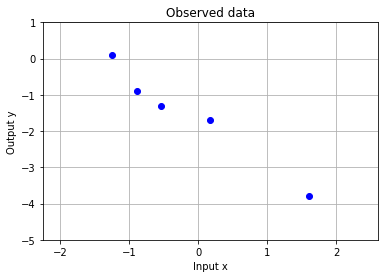

In [4]:
#@title First dataset
#@markdown Let's build a simple dataset, with 6 $(x,y)$ pairs.  

x_data_list_outlier = jnp.array([1, 1.5, 2, 3, 4, 5])
x_data_list_outlier = (x_data_list_outlier - x_data_list_outlier.mean()) / x_data_list_outlier.std() # 
y_data_list_outlier = jnp.array([3.1, 2.1, 1.7, 1.3, -5, -0.8]) - 3

plot_basic_data(x_data_list_outlier, y_data_list_outlier, ylim=[-5, 1])


### Finding plausible solutions manually

When faced with some data, there are often multiple plausible explanations for it, that is multiple plausible functions that fit the data well. Lets try to come up with some plausible functions

**Code Task:** <font color='green'>`Base`</font>
1. Move the two sliders below to set $\color{blue}{b}$ and $\color{blue}{w}$, and press "Run cell" on the code cell below. 
2. Is your $f(x)$ a good fit for the blue data points?
3. Repeat 1-2 until you have between 5 and 10 red lines you are happy with.

In [5]:
parameters_list = [] # Used to track which parameters were tried. 

Plotting line -1.21 * x + -1.9


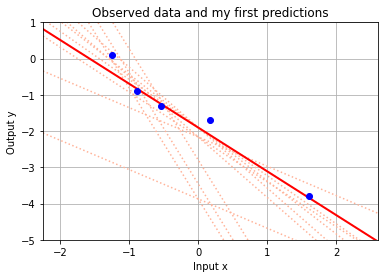

In [16]:
#@title  { run: "auto" }
b = -1.9 #@param {type:"slider", min:-5, max:5, step:0.01}
w = -1.21 #@param {type:"slider", min:-5, max:5, step:0.01}
print("Plotting line", w, "* x +", b)
parameters = [b, w]
parameters_list.append(parameters)
plot_basic_data(x_data_list_outlier, y_data_list_outlier, parameters_list,
                title="Observed data and my first predictions", ylim=[-5, 1])

In [17]:
manual_parameters_list = jnp.array(parameters_list)  # turn your chosen parameter values into a jnp array

### Now with Machine learning:

Now that we have manually solved the problem, we are going to find some regression functions with machine learning.

#### Introducing matrix notation! 

For convinience we are going to work with matrix notation.


Our targets can be written as a vector $\underline{y} = [y_0, y_1, ...]^T$ and the same for our inputs $\underline{x} = [x_0, x_1, ...]^T$. These vectors are of length matching our number of observations $N=6$.


The bias (or offset) $\color{blue}{b}$ in our regression function $f(x, \color{blue}{w, b}) = \color{blue}{b + w} x $ can be written as a product of an additional weight $\color{blue}{b}$ with an input that takes constant value of $1$. That is  $\color{blue}{b + w} x = \color{blue}{b} 1 + \color{blue}{w}x$. Now we have a weight vector $\color{blue}{\underline{w} = [b, w] }$ of dimension $D=2$ and a feature vector $[1, x]$. We can write our vectorised function as $f(x, \color{blue}{\underline{w}}) = [1, x]^T \color{blue}{\underline{w}}$.  

We refer to the mapping $x \to [1, x]$ as a mapping into the *affine basis*. 

When we apply this mapping, we can stack all of our observations into a matrix $X = [[1, x_0], [1, x_1], [1, x_2], ...] \in \mathcal{R}^{N \times 2}$.



Our full dataset is now modelled as $\underline{y} =  X \cdot \color{blue}{\underline{w}}  + \color{red}{\underline{\epsilon}}$



**Coding task:**<font color='green'>`Base`</font>

Implement the mapping onto the affine basis 

* Hint: useful methods are `jnp.concatenate` and `jnp.ones`.

In [18]:

def affine_basis(x):
  """
  Maps a vector of inputs [x_0, x_1, ...] 
  onto the affine basis [[x_0, 1], [x_1, 1], [x_2, 1], ...]
  
  Args:
    x: jnp array of shape (N,) or (N,1)
  Returns:
    X: jnp array of shape (N,2)
  """
  if x.ndim == 1:
    x = x.copy()[:, None]
  
  # Your code goes 
  return X




In [21]:
# @title Run me to test your code


X = affine_basis(x_data_list_outlier)

X_correct = jnp.stack([jnp.ones(len(x_data_list_outlier)), x_data_list_outlier], axis=1)

assert jnp.allclose(X_correct, X), "X is not calculated correctly"

print('It seems correct. Look at the answer below to compare methods.')

It seems correct. Look at the answer below to compare methods.


In [20]:
# @title Answer  (Try not to peek until you've given it a good try!') 

def affine_basis(x):
  """
  Maps a vector of inputs [x_0, x_1, ...] 
  onto the affine basis [[1, x_0], [1, x_1], [1, x_2], ...]
  
  Args:
    x: jnp array of shape (N,) or (N,1)
  Returns:
    X: jnp array of shape (N,2)
  """
  if x.ndim == 1:
    x = x.copy()[:, None]
  
  pad_ones = jnp.ones((len(x), 1)) # the bias can be interpreted as a weight that multiplies an input with a constant value of 1 
  X = jnp.concatenate([pad_ones, x], axis=1)
  return X




In [22]:
#@title Now we implement the linear function
#@markdown it will take a single point as input and then we will vmap it to deal with batches of inputs

def linear(x, w):
  return  x @ w

vmap_linear = jit(vmap(linear, in_axes=(0, None)))


**Group task**: <font color='green'>`Base`</font> - Discuss with a neighbour:

* What does the @ operator do? 
  * Solution: it is the same as [np.dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html)

* What would have been an alternative way to implement the linear function without using @?

* What if we want to evaluate the function for multiple weight settings $\color{blue}{\underline{w}}$, would we need to change our code?

If you are unsure about any of these, get a tutor involved in your discussion!

#### Lets find the line that minimises the loss


**Code task:** <font color='green'>`Base`</font>

Implement the squared error (SE) loss from the introduction to Jax prac:
<center>
$\frac{1}{2}||\underline{y} - X\cdot \color{blue}{\underline{w}}||_{2}^2$
</center>

* Hint: $||\underline{y} - X\cdot \color{blue}{\underline{w}}||_{2}^2 = \sum_{n=1}^{N} (y_n - x_{n} \cdot \color{blue}{\underline{w}})^2$ is just the squared [euclidean norm](https://en.wikipedia.org/wiki/Norm_(mathematics)). The output is a single number.

In [ ]:

def linear_regression_loss(X, y, vmap_model, w):
    """
    Computes SE loss
    
    Args:
      X: jnp array of shape (N,2)
      y: jnp array of shape (N,)
      w: jnp array of shape (w,)
      vmap_model: function that maps (X, w) onto y
    Returns:
      squared_error: scalar
    """
    predictions = vmap_model(X, w)
    squared_error = # Your code goes here
    return squared_error


In [24]:
# @title Run me to test your code


mse = linear_regression_loss(affine_basis(x_data_list_outlier),
                      y_data_list_outlier, vmap_linear, jnp.array([2,2])) 

mse_correct = 0.5 * ((vmap_linear(affine_basis(x_data_list_outlier), jnp.array([2,2])) - y_data_list_outlier) ** 2).sum()

assert jnp.allclose(mse_correct, mse), "X is not calculated correctly"

print('It seems correct. Look at the answer below to compare methods.')

It seems correct. Look at the answer below to compare methods.


In [23]:
# @title Answer  (Try not to peek until you've given it a good try!') 

def linear_regression_loss(X, y, vmap_model, w):
    """
    Computes MSE loss
    
    Args:
      X: jnp array of shape (N,2)
      y: jnp array of shape (N,)
      w: jnp array of shape (w,)
      vmap_model: function that maps (X, w) onto y
    Returns:
      squared_error: scalar
    """
    predictions = vmap_model(X, w)
    squared_error = 0.5 * ((y - predictions) ** 2).sum()
    return squared_error




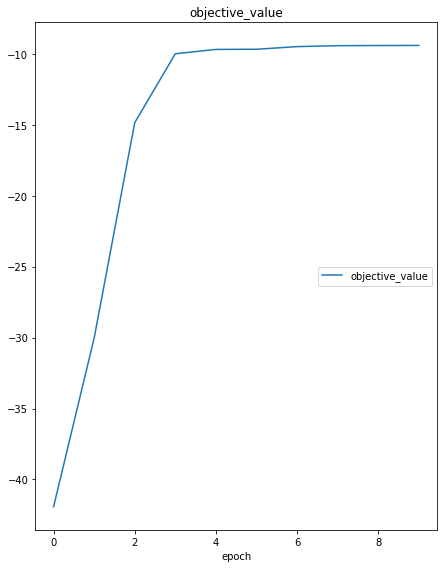

objective_value
	objective_value  	 (min:  -41.920, max:   -9.406, cur:   -9.406)
Your optimised parameter values are [-2.6085892 -2.0239995]


In [25]:
#@title Lets optimise our parameters with the squared error loss
#@markdown Note that in this prac we will be working with objectives which are the inverse of the loss. That means that it is good if the training curve goes up!


def gen_objective(X, y, vmap_model):
  def objective(params, key):
    return -linear_regression_loss(X, y, vmap_model, params)
  return objective 

objective = gen_objective(affine_basis(x_data_list_outlier),
                      y_data_list_outlier, vmap_linear)

optimised_params = optimise(objective, params=jnp.array([0.,0.]), \
                            plotting_func=None, LR=1e-2, MAX_STEPS=1000, LOG_EVERY=100)

print('Your optimised parameter values are', optimised_params)


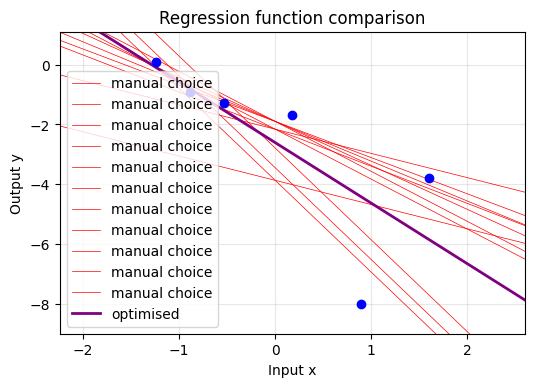

In [26]:
#@title Lets look at how your manually chosen regression functions compare with the optimised one


plt.figure(dpi=100)

xlim = [jnp.min(x_data_list_outlier)-1, jnp.max(x_data_list_outlier)+1]
ylim = [jnp.min(y_data_list_outlier)-1, jnp.max(y_data_list_outlier)+1]

x_test = jnp.linspace(xlim[0], xlim[1], 201)
X_test = affine_basis(x_test)

ax = plt.gca()

ax.plot(x_test, vmap_linear(X_test, manual_parameters_list.T), c='red', lw=0.5, label='manual choice')
ax.plot(x_test, vmap_linear(X_test, optimised_params), c='purple', lw=2, label='optimised')

ax.plot(x_data_list_outlier, y_data_list_outlier, "ob")
ax.set(xlabel="Input x", ylabel="Output y",
      xlim=xlim, ylim=ylim)
ax.grid(alpha=0.3)
ax.set_title('Regression function comparison')
ax.legend(loc='lower left')

**Group task**: <font color='green'>`Base`</font> - Discuss with a neighbour and / or tutor:

* Do your manual choices look similar to those of your neighbour? 

* Are you more confident about the functions you chose or the one that the optimiser chose?

* What went wrong with the optimiser, if anything? Hint: can you spot any previously hidden outliers?



#### How can we make our parameters robust to overfitting to outliers? You already know the solution: adding regularisation!

The outlier above pushes our regression line to have a larger negative slope than we would like. We can bias our slope parameter $\color{blue}{w}$ away from solutions that have a small (possitive or negative) slope by penalising $||\color{blue}{w}||_{2}^2$. This will prevent the outlier from influencing our regression line too much.  


In [27]:

#@markdown Our *regularised* loss is $\frac{1}{2}||\underline{y} - X\cdot \color{blue}{\underline{w}}||_{2}^2 + \frac{\alpha}{2}||\color{blue}{\underline{w}}||_{2}^{2}$

#@markdown where $\alpha$ is the regularisation strength. 

def regularised_linear_regression_loss(X, y, vmap_model, w, alpha):
    predictions = vmap_model(X, w)
    data_fit = 0.5 * ((y - predictions) ** 2).sum()
    regulariser = 0.5 * alpha * (w ** 2).sum()
    return data_fit + regulariser


**Math Task:** <font color='orange'>`Intermediate`</font> (Optional - skip if you are not familiar with matrix calculus)

The regularised least squares solution, i.e. the minimum of $\frac{1}{2}||\underline{y} - X\cdot \color{blue}{\underline{w}}||_{2}^2 + \frac{\alpha}{2}||\color{blue}{\underline{w}}||_{2}^{2}$ can be calculated in closed form with pen and paper.

Try to derive it!

**Hint1:** take derivate with respect to $\color{blue}{\underline{w}}$ and set it to 0 to find the stationary point, i.e. the minimum. 

<center>
$\frac{\partial}{\partial \color{blue}{\underline{w}}} \frac{1}{2}||\underline{y} - X\cdot \color{blue}{\underline{w}}||_{2}^2 + \frac{\alpha}{2}||\color{blue}{\underline{w}}||_{2}^{2} =0
$
</center>

**Hint2:** the derivative is:

<center>
$\frac{\partial}{\partial \color{blue}{\underline{w}}} \frac{1}{2}||\underline{y} - X\cdot \color{blue}{\underline{w}}||_{2}^2 + \frac{\alpha}{2}||\color{blue}{\underline{w}}||_{2}^{2} = X^T (\underline{y} - X\cdot \color{blue}{\underline{w}}) + \alpha \color{blue}{\underline{w}}
$
</center>



In [29]:
#@markdown What is the solution? (Options given already in code)

selection =  'X.T @ X + alpha * jnp.eye(w.shape[0])' #@param ['X.T @ X + alpha * jnp.eye(w.shape[0])', "solve(X.T @ X + alpha * jnp.eye(X.shape[1]), X.T @ y)", "inv(X.T @ X) @ (\alpha + X.T @ y)"]
print(f"You selected: {selection}")

You selected: X.T @ X + alpha * jnp.eye(w.shape[0])


In [31]:
#@title Coding task (Optional): choose one of the 3 options from above

def regularised_least_squares_solution(X, y, alpha):
  return  # paste solution here
  

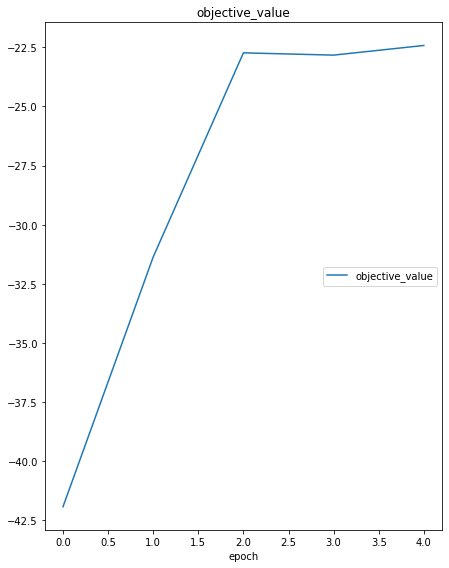

objective_value
	objective_value  	 (min:  -41.920, max:  -22.420, cur:  -22.420)


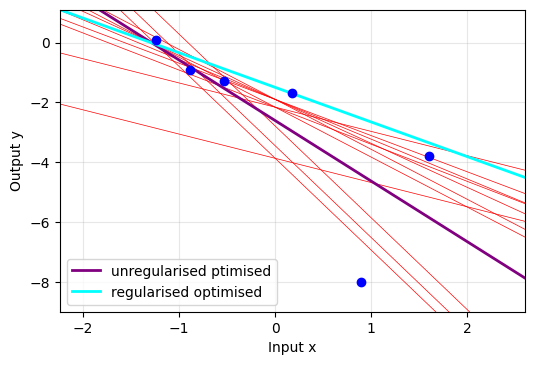

In [41]:
#@title Lets optimise the parameters with the regulariser and lets look at how the manually chosen regression functions compare with the regularised and unregularised ones <font color='green'>`Base`</font> {run: "auto"}

#@markdown **This does not require solving the optional task above**.

#@markdown Lets start with $\alpha=5$.

#@markdown Play around with different $\alpha$ values to find the one that gives solutions that "feel" the best

alpha=3.58 # @param {type:"slider", min:0, max:20, step:0.01}


def gen_objective(X, y, vmap_model, alpha):
  def objective(params, key):
    return -regularised_linear_regression_loss(X, y, vmap_model, params, alpha)
  return objective 

objective = gen_objective(affine_basis(x_data_list_outlier),
                      y_data_list_outlier, vmap_linear, alpha)

optimised_regularised_params = optimise(objective, params=jnp.array([0.,0.]), \
                            plotting_func=None, LR=1e-2, MAX_STEPS=500, LOG_EVERY=100)





plt.figure(dpi=100)

xlim = [jnp.min(x_data_list_outlier)-1, jnp.max(x_data_list_outlier)+1]
ylim = [jnp.min(y_data_list_outlier)-1, jnp.max(y_data_list_outlier)+1]

x_test = jnp.linspace(xlim[0], xlim[1], 201)
X_test = affine_basis(x_test)

ax = plt.gca()

ax.plot(x_test, vmap_linear(X_test, manual_parameters_list.T), c='red', lw=0.5)
ax.plot(x_test, vmap_linear(X_test, optimised_params), c='purple', lw=2, label='unregularised ptimised')
ax.plot(x_test, vmap_linear(X_test, optimised_regularised_params), c='cyan', lw=2, label='regularised optimised')

ax.plot(x_data_list_outlier, y_data_list_outlier, "ob")
ax.set(xlabel="Input x", ylabel="Output y",
      xlim=xlim, ylim=ylim)
ax.grid(alpha=0.3)
ax.legend(loc='lower left')

In [33]:
#@title (Optional) If you coded the exact solution, lets compare it with the output of the optimiser 
#@markdown Note that both parameter vectors will not be exactly the same due to our optimisation not having fully converged.

# Hint: the correct solution to the above question was (b)
exact_regularised_params = regularised_least_squares_solution(affine_basis(x_data_list_outlier), y_data_list_outlier, alpha)

print('Your regularised optimised parameter values are', optimised_regularised_params)
print('Your regularised exact parameter values are', exact_regularised_params)


Your regularised optimised parameter values are [-1.3831213 -1.108413 ]
Your regularised exact parameter values are None


In [35]:
# @title Run me to reveal answer to optional math task above, for reference.
from IPython.display import display, Markdown, Latex
display(("The derivation of the solution to the regularised least squares minima is:"))
display(Latex("$X^T (\\underline{y} - X\cdot {\\underline{w}} ) + \\alpha {\\underline{w}} = 0$"))
display(Latex("$X^T \\underline{y} - X^T X {\\underline{w}} + \\alpha {\\underline{w}} = 0$"))
display(Latex("$X^T \\underline{y} =  (X^T X w + \\alpha I){\\underline{w}} = 0$"))
display(Latex("$\\underline{w} = (X^T X w + \\alpha I)^{-1} X^T \\underline{y}$"))





'The derivation of the solution to the regularised least squares minima is:'

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Lets investigate the loss landscape:  <font color='green'>`Base`</font> 





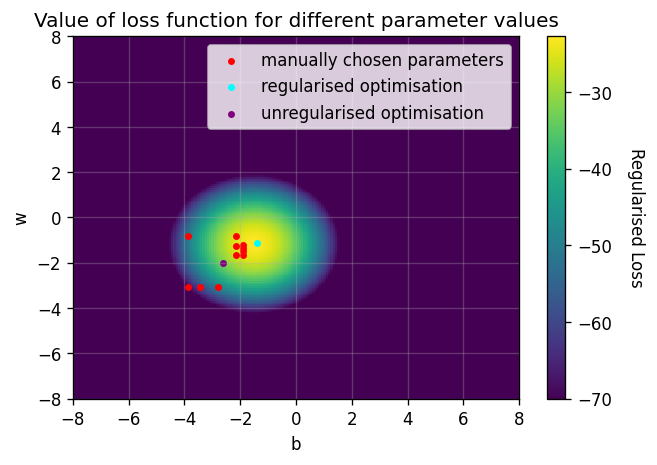

In [40]:
#@title  { run: "auto" }
#@markdown Lets plot the loss for a large grid of $b$ and $w$ values to see which ones would work well

#@markdown Try different values of alpha to see how they affect the loss landscape


alpha = 4.18 # @param {type:"slider", min:0, max:20, step:0.01}

def generate_loss_fun():
  def loss_fun(w):
    return regularised_linear_regression_loss(X=affine_basis(x_data_list_outlier),
                    y=y_data_list_outlier, w=w, vmap_model=vmap_linear, alpha=alpha)
  return loss_fun
loss_fun = generate_loss_fun()

x0_grid, x1_grid, loss_grid = generate_loss_grid(loss_fun=loss_fun, grid_size=200, lim0=[-8,8], lim1=[-8,8])


plt.figure(dpi=120)
plt.pcolormesh(x0_grid, x1_grid, -loss_grid, vmin=-loss_grid.min(), vmax=-70, cmap='viridis') # 
plt.ylabel('w')
plt.xlabel('b')
plt.grid(alpha=0.3)
cbar = plt.colorbar()
cbar.set_label('Regularised Loss', rotation=270, labelpad=20)

plt.scatter(manual_parameters_list[:,0], manual_parameters_list[:, 1], 10, color='red', label='manually chosen parameters')
plt.scatter(optimised_regularised_params[0], optimised_regularised_params[1], 10, color='cyan', label='regularised optimisation')
plt.scatter(optimised_params[0], optimised_params[1], 10, color='purple', label='unregularised optimisation')
plt.title('Value of loss function for different parameter values')
plt.legend()




* The loss landscape accomodates multiple solutions! It turns out that all of the parameter combinations in the yellow region of the loss surface have low loss, they could have worked quite well! 


* For larger values of $\alpha$, the yellow region shrinks and moves towards the origin. This means that out of all the lines that fit the data, we are only keeping the ones that have a smaller parameter norm $||\color{blue}{\underline{w}}||^2_2$.

**Question <font color='green'>`Base`</font>:** Given that we have only seen $N=6$ training points, how confident should we be that the line that minimises the loss function above is the "right" line?



### **Takeaways**: trust your instincts!

1. Our intuition about what is a "good" solution alligns more with the solutions chosen by the regularised objective. 

2. Using our intuition, we were able to come up with multiple plausible options for lines that fit the data. Doesn't it feel kind of wrong that the optimiser only gives us 1 solution?

# Section 1 - From regression to Bayesian linear regression <a name="S1"></a>


In this section, we formalise the intuition from the previous section. We are going to learn about Bayesian inference. 

Specifically, we are going to introduce the concept of probability distribution and show how to update our beliefs using Bayes rule. We will compare Bayesian learning with traditional loss-minimisation learning. Finally, we will look at how to make predictions within the Bayesian framework.

Hopefully, by the end of the section, you will be convinced that when you were manually choosing regression parameters at the beginning of the practical, your brain was performing Bayesian inference!

If you are familiar with probability distributions and Bayes rule, try to breeze through this section and do the optional parts at the end of the section. If it is your first time dealing with these concepts, spend more time on the core section. Aim to spend 45 minutes on the section.

## Bayesian linear regression fundamentals



In the Bayesian framework, we pick a model which we believe could have generated the data. We already have such a model:

<center> 
$\underline{y} =  X \cdot \color{blue}{\underline{w}}  + \color{red}{\underline{\epsilon}}$,
</center>

Although the exact value of $\color{blue}{\underline{w}}$ is unknown a priori (before observing the data), we do have some prior knowledge we can incorporate into our problem. As we saw in the previous section, we might not want to choose a very large slope for our regression line, since this often happens when we overfit to some outlier. 

Mathematically, we express the fact that we do not know what value $\color{blue}{\underline{w}}$ should have, but we think it should be low norm, through the choice of a prior probability distribution $p(\color{blue}{\underline{w}})$ that places more probability mass near 0.

The most common choice to satisfy this condition, and easiest to work with, is the 0 mean Gaussian:

<center> 
$\color{blue}{\underline{w}} \sim \mathcal{N}(0, \alpha^{-1} I)$ where $I$ is the indentity matrix.
</center>

<center> 
<img src="https://i.imgur.com/JWykW0I.png" width="40%" />
</center>

The precision parameter $\alpha$ (inverse of variance) expresses how confident we are that the parameters should be close to 0. If we set $\alpha=0.001$ we are saying that we have a slight preference for a small regression slope but dont have a strong opinion so we are also happy with large slope solutions. If we set $\alpha=100$ we are saying that we are very confident that we should only admit very low slope solutions.

Even if we knew the exact value of $\color{blue}{\underline{w}}$, we would still be unable to retrieve $\underline{y}$ given $X$ and $\color{blue}{\underline{w}}$. This is because, in general, our observations are corrupted by the residuals $\color{red}{\underline{\epsilon}}$. 

$\color{red}{\underline{\epsilon}}$ represents some noise that can not be predicted from $X$ alone, e.g. thermal noise in the measurement of a voltage value or background radiation in radio-astronomy. We usually assume this noise is the cause of outliers, such as the one in our dataset. Since we do not know what value $\color{red}{\underline{\epsilon}}$ takes a priori, we also model $\color{red}{\underline{\epsilon}}$ with a probability distribution $p(\color{red}{\underline{\epsilon}})$.


<center> Lets keep it simple and choose the Gaussian
$  \,\,\,\color{red}{\underline{\epsilon}} \sim \mathcal{N}(0, I)$
</center>


We are ready to write our full probabilistic model. Given inputs and weights, our targets follow the distribution

$p(\underline{y} | X, \color{blue}{\underline{w}}) = \mathcal{N}(\underline{y}; X\cdot \color{blue}{\underline{w}}, I)$ 

Nottice that the mean is our prediction $X\cdot \color{blue}{\underline{w}}$ and the covariance is just the covariance of our residuals $I$.

Our weights follow the distribution

$p(\color{blue}{\underline{w}}) = \mathcal{N}(\color{blue}{\underline{w}}; 0, \alpha^{-1} I)$


 

### (Reminder): Probability density functions and likelihood functions

In this section, we are going to be working with probability distributions over continous random variables. Consider the variable $a \in \mathbb{R}$ distributed $p(a) = \mathcal{N}(a; 0, I)$. Since there are infinite possible values $a$ can take, we assing an infinitesimally small probability to each one. However, not all values of $a$ are equally probable. Since the mean of $\mathcal{N}(a; 0, I)$ is 0, this is the most probable value. We quantify the relative probability of the different values $a$ can take with the **probability density function $p(a)$**. In this section, we will work with these functions.

Unlike probabilities which are restricted to the interval [0, 1], probability densities can take values in [0, $\infty$). 

\
We can compute the probability of $a$ taking a value in the range $[s,s']$ by integrating the density function in this interval $p(a \in [s,s']) = \int_{s}^{s'} p(a) da$. Since the probability of all possible events must sum to 1, we have that $\int_{-\infty}^{\infty} p(a) da = 1$.

When we write $p(\color{blue}{\underline{w}}) = \mathcal{N}(\color{blue}{\underline{w}}; 0, \alpha^{-1} I)$ we are saying that $\color{blue}{\underline{w}}$ has a Gaussian density with mean $0$ and precision $\alpha$. Given a particular value of $\color{blue}{\underline{w}}$, we can evalute its density by evaluating the density function

$p(\color{blue}{\underline{w}}) = \mathcal{N}(\color{blue}{\underline{w}}; 0, \alpha^{-1} I) = \frac{1}{ (2 \pi \alpha)^{D/2} } \exp(\frac{-\alpha \color{blue}{\underline{w}}^T \color{blue}{\underline{w}}}{2})$.

where $D$ is the size of $\color{blue}{\underline{w}}$, i.e. 2. 

\
Nottice that the terms outside the exponential do not contain $\color{blue}{\underline{w}}$. These are known as constants. The term inside the exponential $\frac{-\alpha \color{blue}{\underline{w}}^T \color{blue}{\underline{w}}}{2}$ becomes larger the smaller $\color{blue}{\underline{w}}$ becomes. Its maximum is attained when $\color{blue}{\underline{w}} = 0$.

Assuming we know the value of the weights $\color{blue}{\underline{w}}, our$ targets $\underline{y}$ follow a probability distribution $p(\underline{y} | X, \color{blue}{\underline{w}})$. The vertical line "|" denotes conditioning. $p(\underline{y} | X, \color{blue}{\underline{w}})$ means: "the probability density for $\underline{y}$ conditional on choosing a specific $X$ and $\color{blue}{\underline{w}}$". When we expand this density function, we get

\
$p(\underline{y} | X, \color{blue}{\underline{w}}) = \mathcal{N}(\underline{y}; X\cdot \color{blue}{\underline{w}}, I) = \frac{1}{ (2 \pi)^{N/2} } \exp(\frac{- (y - X \cdot \color{blue}{\underline{w}})^T (y - X \cdot \color{blue}{\underline{w}})}{2})$

where $N$ is the number of observations, i.e. 6.

The distribution $p(\underline{y} | X, \color{blue}{\underline{w}})$ is special
because it is not a distrbution over the variable we care about $\color{blue}{\underline{w}}$. Instead $\color{blue}{\underline{w}}$ is a parameter of the distribution, influencing the value of its mean. However, we can still view $p(\underline{y} | X, \color{blue}{\underline{w}})$ as a function of $\color{blue}{\underline{w}}$. When viewed in this light, probability densities are known as **likelihood functions**. 

Likelihood functions can be used for learning. Specifically, we can choose $\color{blue}{\underline{w}}$ such that the probability of our targets conditional on $\color{blue}{\underline{w}}$, i.e. $p(\underline{y} | X, \color{blue}{\underline{w}})$ is maximised. This is known as **maximum likelihood criteria**. 

<font color='green'>`Fun fact`</font>: A likelihood function does not need to be normalised. As a result, any possitive function can be viewed as a likelihood function. The consequence of this is that any machine learning algorithm that minimises a loss or maximises an objective can be seen as performing maximum likelihood learning.



## Bayesian learning of our parameters $\color{blue}{\underline{w}}$


Learning means identifying the parameter settings that 
1. Are compatible with our prior assumptions, i.e. have low norm. -- this is captured by $p(\color{blue}{\underline{w}})$
**and**
2. Fit the data well. -- this is quantified by the likelihood function $p(\underline{y} | X, \color{blue}{\underline{w}})$

We can score parameter settings by how well they satisfy both constraints simultaneously by considering the product of the prior and likelihood

<center> 
$p(\underline{y} | X, \color{blue}{\underline{w}}) p(\color{blue}{\underline{w}})$.
</center> 

Unfortunately, when you multiply two probability distributions, you are not guaranteed to get something that integrates to 1 (a key requirement for something to be a probability distribution). This is why we need to renormalise by dividing the product above by $p(\underline{y} | X) = \int p(\underline{y} | X, \color{blue}{\underline{w}}) p(\color{blue}{\underline{w}}) d \color{blue}{\underline{w}}$. Putting it all together, we have 


$$\frac{p(\underline{y} | X, \color{blue}{\underline{w}}) p(\color{blue}{\underline{w}})}{p(\underline{y} | X)}$$.


 This expression is known as **Bayes Rule** and it yields our posterior distribution over parameters $p(\color{blue}{\underline{w}} | \underline{y}, X)$. The posterior represents how well each parameter setting agrees with our prior and data. If we compute this distrbution, we will know what are good values of $\color{blue}{\underline{w}}$ with which we can make predictions.

The procedure of computing the posterior is also known as **inference**.

<font color='green'>`Fun fact`</font>: in large scale machine learning, "inference" is used to mean "making predictions". This is a miss-use of the word that stuck!

**Math Task:** <font color='orange'>`Intermediate`</font> (Optional)

Compute the posterior distribution $p(\color{blue}{\underline{w}} | \underline{y}, X) = \frac{p(\underline{y} | X, \color{blue}{\underline{w}}) p(\color{blue}{\underline{w}})}{p(\underline{y} | X)}$ for our linear regression model

$p(\underline{y} | X, \color{blue}{\underline{w}}) = \mathcal{N}(\underline{y}; X\cdot \color{blue}{\underline{w}}, I) = \frac{1}{ (2 \pi)^{N/2} } \exp(\frac{- (y - X \cdot \color{blue}{\underline{w}})^T (y - X \cdot \color{blue}{\underline{w}})}{2})$ 

$p(\color{blue}{\underline{w}}) = \mathcal{N}(\color{blue}{\underline{w}}; 0, \alpha^{-1} I) = \frac{1}{ (2 \pi \alpha)^{D/2} } \exp(\frac{-\alpha \color{blue}{\underline{w}}^T \color{blue}{\underline{w}}}{2})$

\
* Hint 1: The product of Gaussian distributions gives us a Gaussian scaled by a constant $c$. 
<center>
$p(\underline{y} | X, \color{blue}{\underline{w}}) p(\color{blue}{\underline{w}}) = \mathcal{N}(\color{blue}{\underline{w}}; 0, \alpha^{-1} I) \mathcal{N}(\underline{y}; X\cdot \color{blue}{\underline{w}}, I) = c \cdot \mathcal{N}(\color{blue}{\underline{w}}; \mu, \Sigma)$
</center>

$c$ is $p(\underline{y} | X)^{-1}$ and is independent of $\color{blue}{\underline{w}}$ so we dont care about it. Your job is to find $\mu$ and $\Sigma$.

\
* Hint 2: Nottice that $\color{blue}{\underline{w}}$ only appears in the exponential terms of our distributions. This means that we can ignore the non-exponential terms because these will only affect $c$. Thus you need to only consider the expression

<center>
$- (y - X \cdot \color{blue}{\underline{w}})^T (y - X \cdot \color{blue}{\underline{w}}) -\alpha \color{blue}{\underline{w}}^T \color{blue}{\underline{w}} = - (\color{blue}{\underline{w}} - \mu)^T \Sigma^{-1} (\color{blue}{\underline{w}} - \mu)$
</center>

Try to solve for $\Sigma$ first. If you get stuck, ask a tutor!



In [42]:

# @title Answer to math task (Try not to run until you've given it a good try!') 
from IPython.display import display, Markdown, Latex
display("Solution Derivation")
display(Latex("1. Keep only quadratic terms to solve for $\Sigma$"))
display(Latex("$ - \\underline{w}^T X^T   X \\underline{w} - \\alpha \\underline{w}^T \\underline{w} =  - \\underline{w}^T  \Sigma^{-1} \\underline{w} $"))
display("Thus")
display(Latex("$\\Sigma = (X^T X + \\alpha I)^{-1}$"))
display(Latex("2. Keep only first order terms to solve for $\mu$"))
display(Latex("$2 \\underline{w} X^T y =  2 \\underline{w} \Sigma^{-1} \mu$"))
display(Latex("$\mu = \Sigma X^T y "))


'Solution Derivation'

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

'Thus'

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [112]:
#@title **coding task** <font color='green'>`base`</font> : implement a method that computes the posterior distribution for linear regression

#@markdown  Even if you did not solve the math task, the solution is
#@markdown $\Sigma = (X^T X + \alpha I)^{-1} \quad \mu = \Sigma X^T y$ 

def BLR_posterior(X, y, alpha):
    """
    Computes linear regression posterior parameters
    
    Args:
      X: jnp array of shape (N,D)
      y: jnp array of shape (N,)
      alpha: scalar - regulasisation strength
    Returns:
      mu: jnp array of shape (D,)
      covariance: jnp array of shape (D,D)
    """
    D = X.shape[1] # D=2 parameters, one weight and 1 bias
    covariance = # Your code goes here
    mu = # Your code goes here
    return mu, covariance






SyntaxError: ignored

In [44]:
# @title Run me to test your code

alpha = 5
mu, covariance = BLR_posterior(affine_basis(x_data_list_outlier), y_data_list_outlier, alpha)

mu_correct = jnp.array([ -1.4181819, -1.101769 ])
covariance_correct = jnp.array([[9.090909e-02, 9.852008e-10],
 [9.852008e-10, 9.090909e-02]])

assert jnp.allclose(mu_correct, mu), "mu is not calculated correctly"
assert jnp.allclose(covariance_correct, covariance), "Covariance is not calculated correctly"

print('It seems correct. Look at the answer below to compare methods.')

It seems correct. Look at the answer below to compare methods.


In [43]:
# @title Answer  (Try not to peek until you've given it a good try!') 

def BLR_posterior(X, y, alpha):
    """
    Computes linear regression posterior parameters
    
    Args:
      X: jnp array of shape (N,D)
      y: jnp array of shape (N,)
      alpha: scalar - regulasisation strength
    Returns:
      mu: jnp array of shape (D,)
      covariance: jnp array of shape (D,D)
    """
    D = X.shape[1] # D=2 parameters, one weight and 1 bias
    precision = X.T @ X + alpha * jnp.eye(D)
    covariance = jnp.linalg.inv(precision)
    mu = solve(precision, (X.T @ y))
    return mu, covariance



### The posterior is just the loss, but normalised!

Recall that the posterior is computed as $\frac{p(\underline{y} | X, \color{blue}{\underline{w}}) p(\color{blue}{\underline{w}})}{p(\underline{y} | X)}$ and the denominator is just a normalising constant independent of $\color{blue}{\underline{w}}$.

Consider the log of the unnormalised posterior

<center>
$\log \left( p(\underline{y} | X, \color{blue}{\underline{w}}) p(\color{blue}{\underline{w}}) \right) = \log \left( \mathcal{N}(\underline{y}; X\cdot \color{blue}{\underline{w}}, I) \mathcal{N}(\color{blue}{\underline{w}}; 0, \alpha^{-1} I)\right)$

\
$= \frac{- (y - X \cdot \color{blue}{\underline{w}})^T (y - X \cdot \color{blue}{\underline{w}})}{2} + \frac{-\alpha \color{blue}{\underline{w}}^T \color{blue}{\underline{w}}}{2} + C$

\
$= \frac{-1}{2}||\underline{y} - X\cdot \color{blue}{\underline{w}}||_{2}^2 + \frac{-\alpha}{2}||\color{blue}{\underline{w}}||_{2}^{2} + C$

</center>

where $C$ is a constant independent of $\color{blue}{\underline{w}}$. 

**We recover our regularised loss function!!** This can help us build intuition about the posterior density of $\color{blue}{\underline{w}}$: it is a function that assigns to each $\color{blue}{\underline{w}}$ a density which is larger the larger density that $\color{blue}{\underline{w}}$ has under our prior and the better that $\color{blue}{\underline{w}}$ fits the data.

Since the log is a monotonic function, we have just derived that the weight settings that minimise our loss are the same ones that minimise our posterior! 

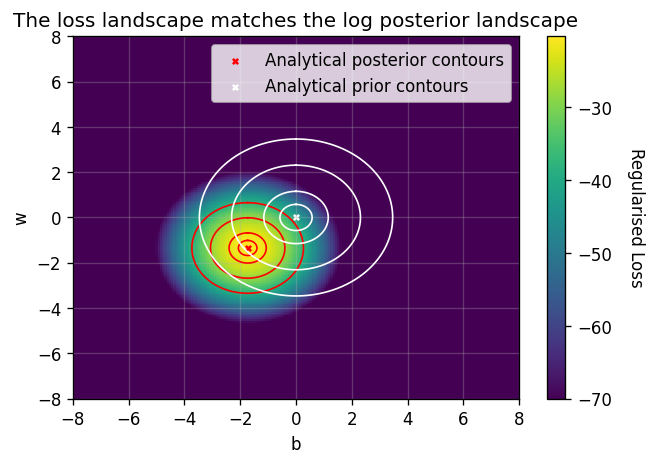

In [50]:
#@title We can plot our log posterior distribution by plotting our loss landscape, since both are equal up to a constant. {run : 'auto'}

#@markdown **Plotting task** <font color='green'>`Base`</font>: Try different values of $\alpha$ to see how the prior and posterior change

#@markdown Note: the concentric lines in the plot, also known as level-sets or contours, allow us to see how fast the value of a function decreases. If the contours are very close to each other, it means that the function decreases fast.

alpha = 3  # @param {type:"slider", min:0.01, max:20, step:0.01
mu, covariance = BLR_posterior(affine_basis(x_data_list_outlier), y_data_list_outlier, alpha)

def generate_loss_fun():
  def loss_fun(w):
    return regularised_linear_regression_loss(X=affine_basis(x_data_list_outlier),
                    y=y_data_list_outlier, w=w, vmap_model=vmap_linear, alpha=alpha)
  return loss_fun
loss_fun = generate_loss_fun()

x0_grid, x1_grid, loss_grid = generate_loss_grid(loss_fun=loss_fun, grid_size=200, lim0=[-8,8], lim1=[-8,8])


plt.figure(dpi=120)
plt.pcolormesh(x0_grid, x1_grid, -loss_grid, vmin=-loss_grid.min(), vmax=-70, cmap='viridis') # 
plt.ylabel('w')
plt.xlabel('b')
plt.grid(alpha=0.3)
cbar = plt.colorbar()
cbar.set_label('Regularised Loss', rotation=270, labelpad=20)

ax = plt.gca()
plot_log_gaussian_ellipse(ax=ax, mean=mu, cov=covariance, color='r',
                          alpha=1, lw=1, label='Analytical posterior contours', MAP_size=10, std_levels=[1, 2, 4, 6])
plot_log_gaussian_ellipse(ax=ax, mean=jnp.array([0,0.]), cov=(alpha**-1)*jnp.eye(2), color='w',
                          alpha=1, lw=1, label='Analytical prior contours', MAP_size=10, std_levels=[1, 2, 4, 6])
plt.title('The loss landscape matches the log posterior landscape')
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.legend()




In the above plot, the Bayesian posterior computed with our method (red lines) corresponds exactly with the loss regions.

Thus, Bayesian inference is just trying to find all of the parameter settings that have low loss, i.e. that fit both our regulariser and data well.

Nottice that the posterior is always "contained within" the prior contours. One interpretation of the posterior is that it is the region of the prior with parameters that fit the data well. The tighter the prior, the tighter that the posterior will be.



**Group task**: <font color='green'>`Base`</font> - Discuss with a neighbour or tutor:

* How does Bayesian learning relate to traditional loss minimisation learning?

* How does the Bayesian posterior relate to the loss landscape?

* Can Bayesian learning be performed for any model for which traditional loss minimisation is used?

* When the posterior is wider, what does it say about our knowledge of the parameters $\color{blue}{\underline{w}}$. What about when it is narrower?

* For larger values of $\alpha$ the posterior becomes narrower. What implications do you think this will have for our predictions?

* Do you think that observing more data would make the posterior wider or narrower?


## Making predictions the Bayesian way!

Once that we have our posterior distribution over $\color{blue}{\underline{w}}$, we are ready to make predictions.

Instead of taking the optimum of the loss and just making predictions with that parameter setting, the Bayesian approach is to make predictions with all parameter settings and weight them by their density under the posterior. 

In other words, we go from a probability distribution over weights to a probability distribution over outputs.

In our particular case, we want to push the weight distribution 

<center>
$\mathcal{N}(\color{blue}{\underline{w}}; \mu, \Sigma)$
</center>

 through our function 
 <center>
 $f(X, \color{blue}{\underline{w}}) = X \color{blue}{\underline{w}}$
 </center>


A nice property of Gaussians is that linear transformations of Gaussian random variables are also Gaussian with mean $X \mu $ and covariance $X \Sigma X^T$.

Thus $X\cdot \color{blue}{\underline{w}} \sim \mathcal{N}(X \cdot \mu, X \Sigma X^T)$



In [48]:
#@title Exact predictive posterior for Bayesian Linear regression

#@markdown Here is the code to implement this.

#@markdown Instead of returning the full covariance, we will return the square root of the diagonal $\sqrt{\textrm{diag}(\Sigma)}$. This is the predictive standard deviation. The std dev is nice for plotting because its scale matches that of the data.


def BLR_predictions(X, mu, covariance):
    """
    Computes linear regression posterior predictive distribution.
    Instead of returning the full covariance we will return the square root of the diagonal. This is the predictive standard deviation, which is nice for plotting.

    Args:
      X: jnp array of shape (N,D)
      mu: jnp array of shape (D,)
      covariance: jnp array of shape (D,D)
    Returns:
      predictive_mean: jnp array of shape (N,)
      predictive_std: jnp array of shape (N,)
    """
    predictive_mean = X @ mu
    predictive_std = jnp.diag(X @ covariance @ X.T) ** 0.5
    return predictive_mean, predictive_std
    


Text(0.5, 1.0, 'predictive mean + 1 standard deviation errorbars on either side')

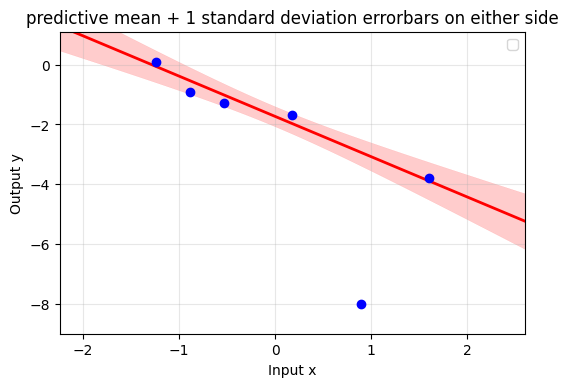

In [53]:
#@title **Plotting task** <font color='green'>`Base`</font>: Lets look at the posterior predictive distribution for different values of $\alpha$ {run : 'auto'}

alpha = 3.  # @param {type:"slider", min:0.01, max:20, step:0.01
mu, covariance = BLR_posterior(affine_basis(x_data_list_outlier), y_data_list_outlier, alpha)


plt.figure(dpi=100)

xlim = [jnp.min(x_data_list_outlier)-1, jnp.max(x_data_list_outlier)+1]
ylim = [jnp.min(y_data_list_outlier)-1, jnp.max(y_data_list_outlier)+1]

x_test = jnp.linspace(xlim[0], xlim[1], 201)
X_test = affine_basis(x_test)

predictive_mean, predictive_std = BLR_predictions(X_test, mu, covariance)

ax = plt.gca()
errorfill(x_test, predictive_mean, predictive_std, color='red', alpha_fill=0.2, line_alpha=1, ax=ax,
              lw=2, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label=None, markevery=None)


ax.plot(x_data_list_outlier, y_data_list_outlier, "ob")
ax.set(xlabel="Input x", ylabel="Output y",
      xlim=xlim, ylim=ylim)
ax.grid(alpha=0.3)
ax.legend()
plt.title('predictive mean + 1 standard deviation errorbars on either side')



### Making predictions by sampling

The uncertainty in our posterior distribution over $\color{blue}{\underline{w}}$ translates to uncertainty (errorbars) in our predictions.



We can get more concrete intuition about how this happens, by drawing $K$ samples from our posterior distribution over parameters 

<center>
$ \color{blue}{\underline{w}}_{k} \sim \mathcal{N}(\mu, \Sigma)$
</center>

and pushing them through our function $f$ to obtain $K$ different regression lines 

<center>
$X \color{blue}{\underline{w}}_{1}, X \color{blue}{\underline{w}}_{2}, ..., X\color{blue}{\underline{w}}_{K}$
</center> 

We can then estimate the predictive mean $\mu_f$ and predictive standard deviation $\sigma_f$ from these samples:

<center>
$\mu_f = X \mu = \mathbb{E}[X \color{blue}{\underline{w}}] \approx \frac{1}{K}\sum_{k=1}^K X \color{blue}{\underline{w}}_{k}$
</center>


<center>
$\sigma_f = \sqrt{\textrm{diag}(X \Sigma X^T)} =  \sqrt{\mathbb{E}[(X \color{blue}{\underline{w}} - \mu_f)^2]} \approx \sqrt{\frac{1}{K}\sum_{k=1}^K (X \color{blue}{\underline{w}}_{k} - \mu_f)^2}$
</center>


This procedure of estimating expectations as averages over samples is known as **Monte Carlo estimation**. Even if the exact expression for the predictive posterior were not available, we could always rely on Monte Carlo to make predictions (and we will do that in the next sections).



In [54]:
key = random.PRNGKey(0)
Nsamples = 10

parameter_samples = jax.random.multivariate_normal(key, mu, covariance, shape=(Nsamples,))
sample_preds = vmap_linear(X_test, parameter_samples.T)
MC_mean = sample_preds.mean(axis=1)
MC_std = sample_preds.std(axis=1)



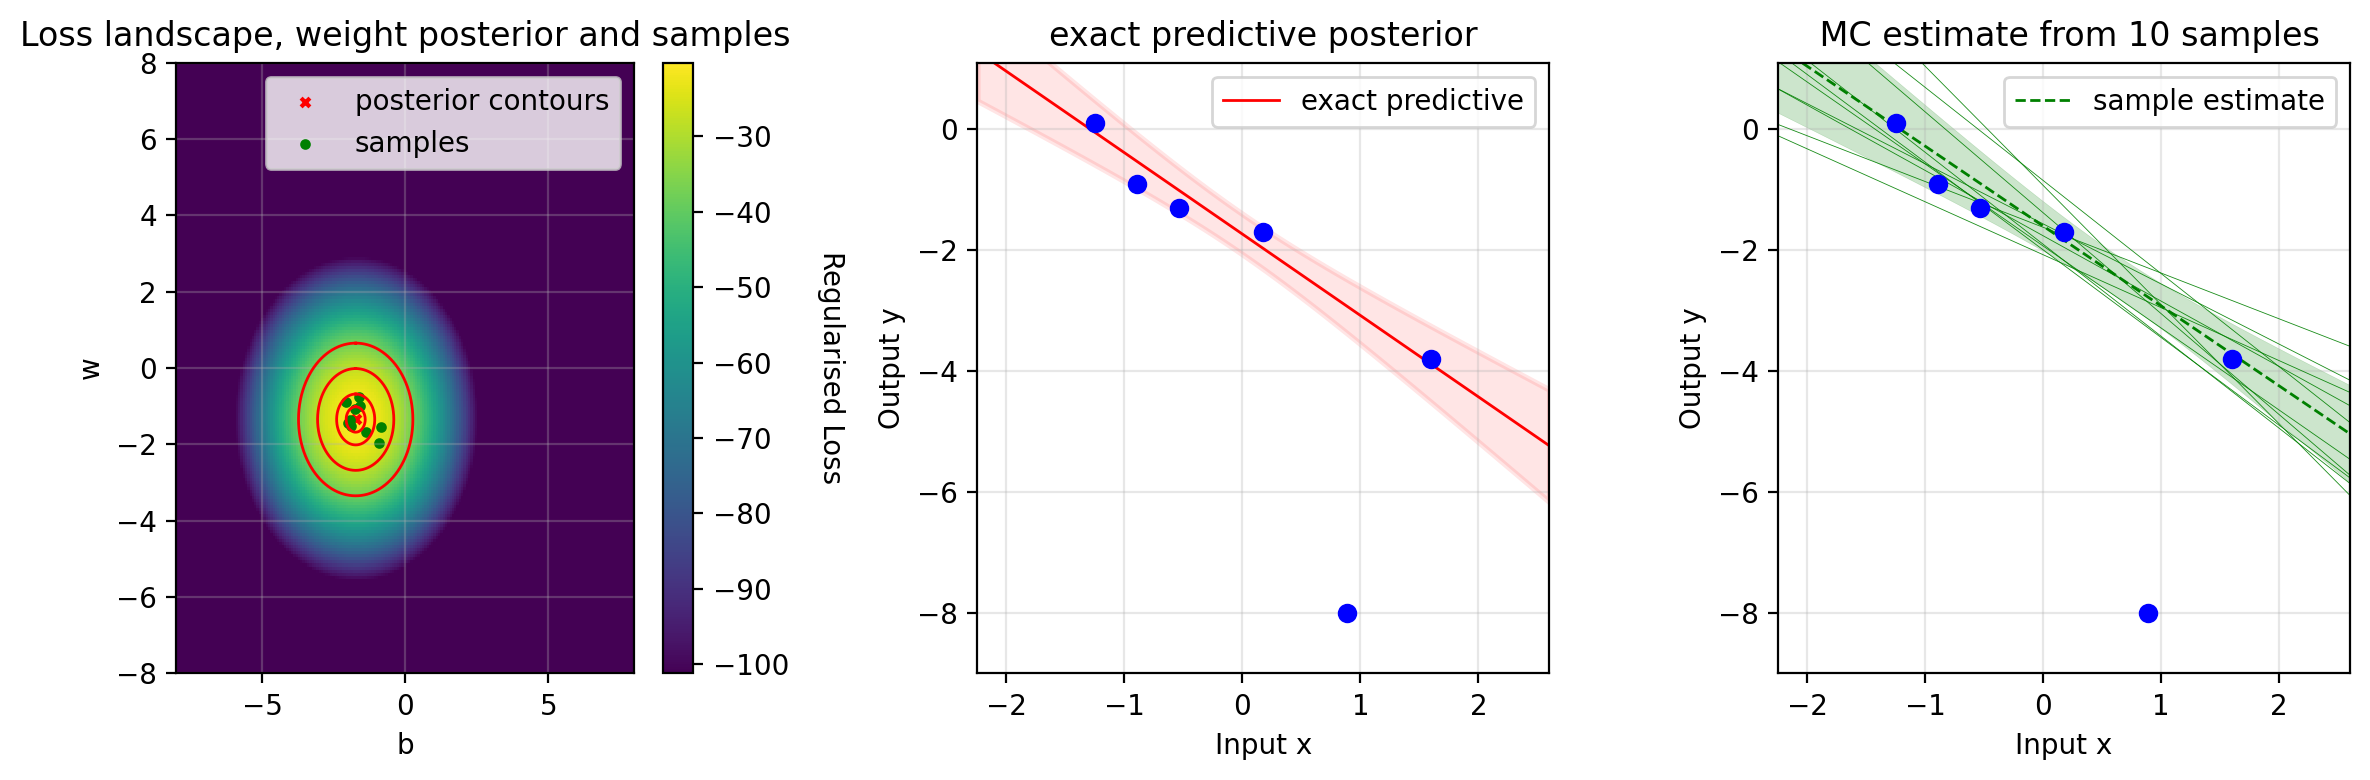

In [57]:
#@title visualizing the Monte Carlo estimate of the predictive posterior

fig, ax = plt.subplots(1,3, dpi=200, figsize=(12,4))


loss_landscape = ax[0].pcolormesh(x0_grid, x1_grid, -loss_grid, vmin=-loss_grid.min() * 5, vmax=-loss_grid.min(), cmap='viridis') # 
ax[0].set_ylabel('w')
ax[0].set_xlabel('b')
ax[0].grid(alpha=0.3)
ax[0].set_title('Loss landscape, weight posterior and samples')

plot_log_gaussian_ellipse(ax=ax[0], mean=mu, cov=covariance, color='r',
                          alpha=1, lw=1, label='posterior contours', MAP_size=10, std_levels=[1, 2, 4, 6])

ax[0].scatter(parameter_samples[:,0], parameter_samples[:,1], 8, color='green', label='samples')
cbar = fig.colorbar(loss_landscape, ax=ax[0])
cbar.set_label('Regularised Loss', rotation=270, labelpad=20)
ax[0].legend()



xlim = [jnp.min(x_data_list_outlier)-1, jnp.max(x_data_list_outlier)+1]
ylim = [jnp.min(y_data_list_outlier)-1, jnp.max(y_data_list_outlier)+1]

x_test = jnp.linspace(xlim[0], xlim[1], 201)
X_test = affine_basis(x_test)

errorfill(x_test, predictive_mean, predictive_std, color='red', alpha_fill=0.1, line_alpha=1, ax=ax[1],
              lw=1, linestyle='-', fill_linewidths=2, marker=None, markersize=1, label='exact predictive', markevery=None)



ax[1].plot(x_data_list_outlier, y_data_list_outlier, "ob")
ax[1].set(xlabel="Input x", ylabel="Output y",
      xlim=xlim, ylim=ylim)
ax[1].grid(alpha=0.3)
ax[1].legend()
ax[1].set_title(f'exact predictive posterior')

ax[2].plot(x_test, sample_preds, "-", color='green', lw=0.3, alpha=0.9)
errorfill(x_test, MC_mean, MC_std, color='green', alpha_fill=0.2, line_alpha=1, ax=ax[2],
              lw=1, linestyle='--', fill_linewidths=0.2, marker=None, markersize=1, label='sample estimate', markevery=None)



ax[2].plot(x_data_list_outlier, y_data_list_outlier, "ob")
ax[2].set(xlabel="Input x", ylabel="Output y",
    xlim=xlim, ylim=ylim)
ax[2].grid(alpha=0.3)
ax[2].legend()
ax[2].set_title(f' MC estimate from {Nsamples} samples')


plt.tight_layout()



**Group task** <font color='green'>`Base`</font> - Discuss with a neighbour:

* Is our sample based estimate of the predictive distribution good? Do we have enough samples?
* Why are the errorbars of the predictive posterior less wide near the middle of the plot data?
* How would the errorbars change if we added more data (observations)? What about if we decreased the number of observations? What about if we increased the regularisation strength?
* What observation (as in [x, y] value pair) would we have to make to maximally decrease the errorbar size?

## Takeaways

* Bayesian learning specifies our prior beleifs about what our function will look like explicitly through the choice of a prior distribution. Bayesian learning uses Bayes rule to update this prior distribution with our data. Specifically, out of all the parameter settings allowed by our prior, we only keep the ones that have a high likelihood (that fit the data well).

* The Bayesian posterior distribution is just the regularised loss normalised by a constant that makes it integrate to 1. Thus, weight settings that have large posterior density are those that have low loss.

* We make predictions by combining the predictions from every possible parameter setting, weighed by their respective posterior densities. Disagreement among the regression lines from these parameter settings induces uncertainty in the predictions. When exact computations are not tractable, we can estimate the predictive distribution with Monte Carlo.

## End of Section

The rest of the section contains more advanced optional contents. You can skip to [Section 2](#S2) if you want

## With a more sophisticated basis linear regression can be very powerfull (Optional) - <font color='orange'>`Intermediate`</font>

Lets introduce a dataset that requires a non-linear model.


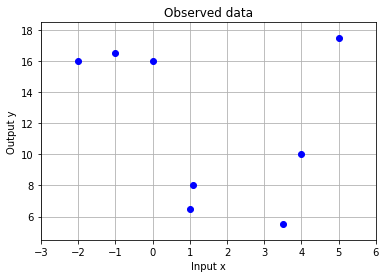

In [58]:
x_data_list_nonlinear = jnp.array([-2, -1, 0, 1, 1.1, 3.5, 4, 5])
y_data_list_nonlinear = jnp.array([3.2, 3.3, 3.2, 1.3, 1.6, 1.1, 2., 3.5]) * 5

plot_basic_data(x_data_list_nonlinear, y_data_list_nonlinear)



### A non-linear basis


So far we have used the affine basis $x \to [1, x]$. This allows us to generate lines with a learnt slope and offset. 

Now consider the basis $x \to [\cos(s_{0} x + u_{0}), \cos(s_{1} x + u_{1}), \,..., \cos(s_{D} x + u_{D})]$ where $\,\,s_{i} \sim \mathcal{N}(0, \sigma_s^{2})$ and $\,\,u_{i} \sim U(-\pi, \pi)$.

This is known as "random fourier" basis and given a large enough number of basis functions $D$, it will allow us to model any function. See the paper [Random Features for Large-Scale Kernel Machines](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf) for more details on this basis.


In [59]:

def generate_cosine_basis(key, N_inputs, N_elements, s_std=1):
  
  key, _ = random.split(key)
  S = random.normal(key, shape=(N_inputs, N_elements)) * s_std
  key, _ = random.split(key)
  u = (random.uniform(key, shape=(N_elements,)) - 0.5) * 2 * jnp.pi

  def basis_expand(x):
    if x.ndim == 1:
      x = x.copy()[:,None]
    return jnp.cos(x @ S + u) / np.sqrt(N_elements)

  return basis_expand





In [61]:
alpha = 0.001
std_s = 0.75

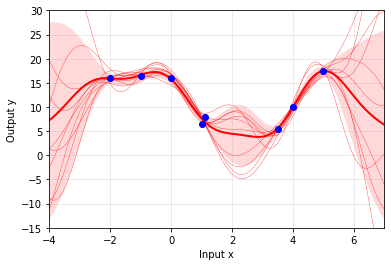

In [113]:
#@title Run regression using the code from this section but with the affine basis

#@markdown As before, the thick red line is the predictive mean, the transparent bars represent the standard deviation. The lin lines represent posterior samples.

N_inputs = 1
N_elements = 500
alpha = 0.001
std_s = 0.75

key = random.PRNGKey(42)

def gen_plots(params):

  xlim = [-4, 7]

  alpha = params[1]
  fourier_basis = generate_cosine_basis(key, N_inputs, N_elements, s_std=params[0])

  X = fourier_basis(x_data_list_nonlinear)
  mu, covariance = BLR_posterior(X, y_data_list_nonlinear, alpha)


  x_pred = jnp.linspace(xlim[0], xlim[1], 101)
  X_pred = fourier_basis(x_pred)


  parameter_samples = jax.random.multivariate_normal(key, mu,  covariance, shape=(Nsamples,))
  sample_preds = vmap_linear(X_pred, parameter_samples.T)

  predictive_mean, predictive_std = BLR_predictions(X_pred, mu, covariance)

  #################

  fig, ax = plt.subplots()
  ylim = [-15, 30]
  ax.plot(x_pred, sample_preds, "-", color='red', lw=0.3)

  errorfill(x_pred, predictive_mean, predictive_std, color='red', alpha_fill=0.15, line_alpha=1, ax=ax,
                lw=2, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label=None, markevery=None)

  ax.plot(x_data_list_nonlinear, y_data_list_nonlinear, "ob")
  ax.set(xlabel="Input x", ylabel="Output y",
        xlim=xlim, ylim=ylim)
  ax.grid(alpha=0.3)

gen_plots([std_s, alpha])


**Group task** (Optional) <font color='orange'>`Intermediate`</font>: - Discuss with a neighbour:

* Why do the errorbars grow so large in the [1, 3] range and outside the x = [-1, 5] range?
* What effect does $\alpha$ have? What about the random frequency standard deviation $\sigma$? 

## The model evidence for hyperparameter selection (Optional) - <font color='red'>`Advanced`</font>


Recall Bayes rule $\frac{p(\underline{y} | X, \color{blue}{\underline{w}}) p(\color{blue}{\underline{w}})}{p(\underline{y} | X)}$. In the beginning of the section, we discounted the normalising constant $p(\underline{y} | X) $ as not important due to it being constant in $\color{blue}{\underline{w}}$.

However, this term, which is known as the **Model evidence** or **Marginal likelihood** (both expressions mean exactly the same thing), can be very useful. To see this consider the expanded expression:

<center>
$p(\underline{y} | X) = \int p(\underline{y} | X, \color{blue}{\underline{w}}) p(\color{blue}{\underline{w}}) d \color{blue}{\underline{w}}$
</center>

it is the integral of the likelihood $p(\underline{y} | X, \color{blue}{\underline{w}})$, which measures data fit, against the prior density $p(\color{blue}{\underline{w}})$. This expression is very similar to that of the predictive posterior, except that the distribution we integrate agaisnt is the prior and not the posterior. 

**The marginal likelihood tells us how well we fit the data with the prior. It can be used as a learning objective for prior hyperparameters**, such as the random fourier coefficient variance $\sigma^2_s$ or prior precision $\alpha$. When we use the marginal likelihood, our weights $\color{blue}{\underline{w}}$ are integrated out -- the only free parameters are those of our prior. Since our prior will usually have a small number of parameters, we can usually fit these safely using all of our data without fear of overfitting. 



In the Gaussian linear model, we compute the marginal likelihood as 

<center>
$p(\underline{y} | X) = \int \mathcal{N}(\underline{y}; X\cdot \color{blue}{\underline{w}}, I) \mathcal{N}(\color{blue}{\underline{w}}; 0, \alpha^{-1} I) d \color{blue}{\underline{w}}$
</center>

You can try to solve this integral as a take-home excercise ([this](https://www.utstat.utoronto.ca/~radford/sta414.S11/week4a.pdf) is a nice resource to help you). To save time, we provide the solution here. In practise we work with logs for numerical stability.

$\log p(\underline{y} | X)$ = $-\frac{1}{2}||\underline{y} - X\cdot \mu||_{2}^2 - \frac{\alpha}{2}||\mu||_{2}^{2} + \frac{1}{2} \textrm{logdet}(\Sigma) + \frac{D}{2}  \log \alpha - \frac{1}{2} N \log(2 \pi)$


The next cell contains an implementation

In [63]:
def linear_evidence(x_data_list, y_data_list, basis, alpha):
    X = basis(x_data_list)
    mu, covariance = BLR_posterior(X, y_data_list, alpha)
    loss = regularised_linear_regression_loss(X=X,
                    y=y_data_list, w=mu, vmap_model=vmap_linear, alpha=alpha)
    a, log_det = jnp.linalg.slogdet(covariance)
    return -loss + 0.5 * (len(mu) * jnp.log(alpha) + log_det) - 0.5 * len(x_data_list) * jnp.log(2 * jnp.pi) 



In [69]:
#@markdown Lets compute the evidence of our affine model and random fourier model on the new non-linear data

alpha= 0.01
s_std = 0.75
fourier_basis = generate_cosine_basis(key, N_inputs, N_elements, s_std)
fourier_evidence = linear_evidence(x_data_list_nonlinear, y_data_list_nonlinear, fourier_basis, alpha)
affine_evidence = linear_evidence(x_data_list_nonlinear, y_data_list_nonlinear, affine_basis, alpha)
print('fourier_evidence', fourier_evidence)
print('affine_evidence', affine_evidence)


fourier_evidence -27.609333
affine_evidence -95.67348


**Some questions** <font color='red'>`Advanced`</font>
* Why is the fourier model's evidence larger than the affine model's evidence?
* Is the same true for the other dataset? (x_data_list_outlier, y_data_list_outlier) -- you might need to tune alpha manually for each model

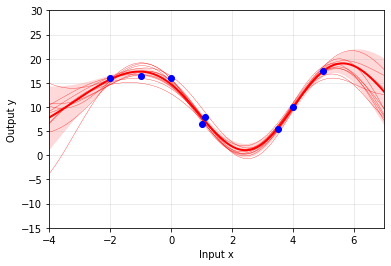

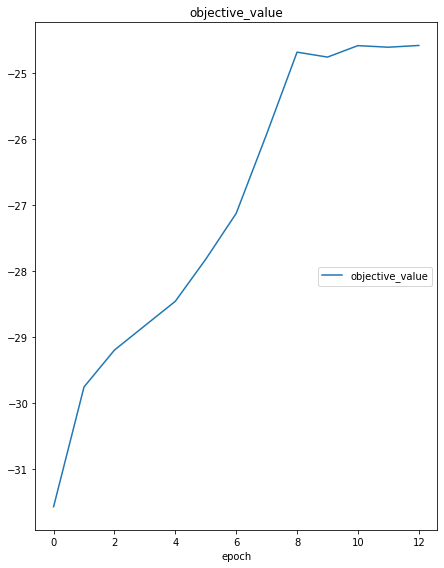

objective_value
	objective_value  	 (min:  -31.574, max:  -24.581, cur:  -24.581)


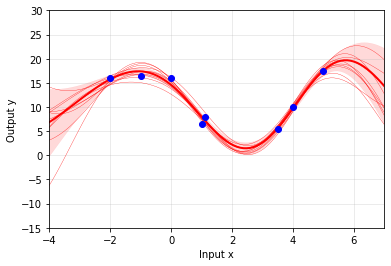

In [70]:
#@title **Plotting Task** (Optional) <font color='red'>`Advanced`</font>: Optimise the fourier basis standard deviation $\sigma$ and the regularisation strength $\alpha$ with the linear evidence objective


def gen_objective(x_data_list, y_data_list, key, N_elements):
  def objective(params, key):
    basis = generate_cosine_basis(key, 1, N_elements, s_std=params[0])
    return linear_evidence(x_data_list, y_data_list, basis, params[1])
  return objective 

N_elements = 300
objective = gen_objective(x_data_list_nonlinear, y_data_list_nonlinear, key, N_elements)

optimised_regularised_classification_params = optimise(objective, params=jnp.array([2, 0.001]), \
                            plotting_func=gen_plots, LR=2e-3, MAX_STEPS=1300, LOG_EVERY=100)




**Some more questions** <font color='red'>`Advanced`</font>
* Is there any overfitting happening? 
* Do the errorbars become bigger or smaller? Why?
* When is it safe to use the model evidence as a training objective for our hyperparameters?

# Section 2 - Logistic Regression -- the need for approximate inference <a name="S2"></a>

Linear regression was nice because the posterior distribution over the parameters and the predictive posterior could be written down in closed form.
We are now ready to exit the world of exact solutions which you can compute with pen and paper. This is a short section meant as motivation for the rest of the prac. Spend no more than 10 minutes on it.

We will start by considering logistic regression. We are going to deal with a classification task where our targets are either 0 or 1. Data that takes these values can be described by a [Bernouilli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution)

<center>
$y_{n} \sim \text{Bern}(\rho)$
</center>

where $\rho \in [0,1]$ is the probability of our observations taking a value of 1.  Our model will predict this probability for each of the inputs: $\rho = f(x, \color{blue}{\underline{w}})$.

We will use the same affine linear model as before, but we need to restrict the output to the $[0,1]$ range. For this, we use the sigmoid function $\phi(f) = \frac{1}{1 + \exp(-f)}$.




The final piece of the puzzle is introducing the standard assumption that our target labels $\underline{y} | X, \color{blue}{\underline{w}}$  are [independent and identically distributed](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) (i.i.d) given our 
inputs and weights. This assumption is going to allow us to write the likelihood as a product of the likelihoods from individual datapoints $p(\underline{y} | X, \color{blue}{\underline{w}}) = \prod_{n=1}^N p(y_n | x_n, \color{blue}{\underline{w}})$. 

We were also implicitly making this assumption in the previous section when choose the covariance of our likelihood function to be the identity. We just did not write out the likelihood as a product to keep the notation compact.


Putting it all together we have 

<center>
$p(\underline{y} | X, \color{blue}{\underline{w}}) = \prod_{n=1}^N Bern(y_{n}; \phi(x_{n}\color{blue}{\underline{w}}))$

and as before we keep the Gaussian prior over our parameters
\
$p(\color{blue}{\underline{w}}) = \mathcal{N}(\color{blue}{\underline{w}}; 0, \alpha^{-1} I)$
</center>

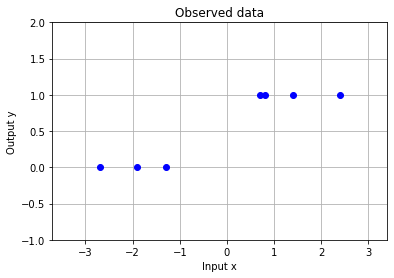

In [71]:
#@title Dataset for logistic regression.
#@markdown the task will be to classify points with the labels 0 or 1

x_data_list_classification = jnp.array([-2.7, -1.9, -1.3, 0.7, 0.8, 1.4, 2.4])
y_data_list_classification = jnp.array([0, 0, 0, 1, 1, 1, 1])


plot_basic_data(x_data_list_classification, y_data_list_classification)



In [72]:
#@title Define the model, same as above but with sigmoid

def logistic(w, x):
  return sigmoid(linear(w, x))

vmap_logistic = jit(vmap(logistic, in_axes=(None, 0)))



## Loss landscape for classification


Similarly to linear reression, lets write out the unnormalised posterior to get a loss function to optimise. 

<center>
$\log \left( p(\underline{y} | X, \color{blue}{\underline{w}}) p(\color{blue}{\underline{w}}) \right) = \log \left( \prod_{n=1}^N Bern(y_n ; \phi(x_n \color{blue}{\underline{w}})) \mathcal{N}(\color{blue}{\underline{w}}; 0, \alpha^{-1} I)\right)$
</center>

\
Now we note that the Bernouilli distribution is defined over discrete outcomes. In the previos sections, we dealt with Gaussian targets that could take any value in $\mathcal{R}$ and thus we dealt with probability density functions. Now our targets can only take values $\{0,1\}$ and thus we can assign each of these outcomes a **probability mass**. The Bernouilli probability mass function is $Bern(y ; \rho) = \rho^y (1-\rho)^{(1-y)}$. When we take its log we recover the cross entropy loss: $y \log \rho + (1-y) \log (1-\rho)$


\
Dropping constants, the total loss is thus going to be

<center>
$\sum_{n=1}^N y_n \log \phi(x_n \color{blue}{\underline{w}}) + (1-y_n) \log (1-\phi(x_n \color{blue}{\underline{w}})) + \frac{\alpha}{2} ||\color{blue}{\underline{w}}||_{2}^2$
</center>

**i.e. the regularised cross entropy loss falls right out of our Bayesian model!!**

In [74]:
#@title Implementation of regularised cross entropy loss
#@markdown nottice that we do not code the sigmoid since it is implicit in the `sigmoid_binary_cross_entropy` method

#@markdown combining sigmoid and cross entropy in this way provides increased numerical stability

def logistic_regression_loss(X, y, vmap_model, w, alpha):
    data_fit_loss = sigmoid_binary_cross_entropy(vmap_model(X, w), y).sum(axis=0) # optax loss has sigmoid integrated so we just use linear model
    parameter_norm = 0.5 * alpha * (w ** 2).sum()
    return (data_fit_loss + parameter_norm)



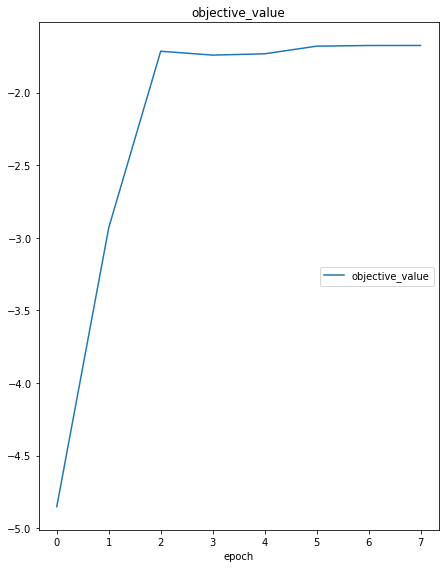

objective_value
	objective_value  	 (min:   -4.852, max:   -1.675, cur:   -1.675)


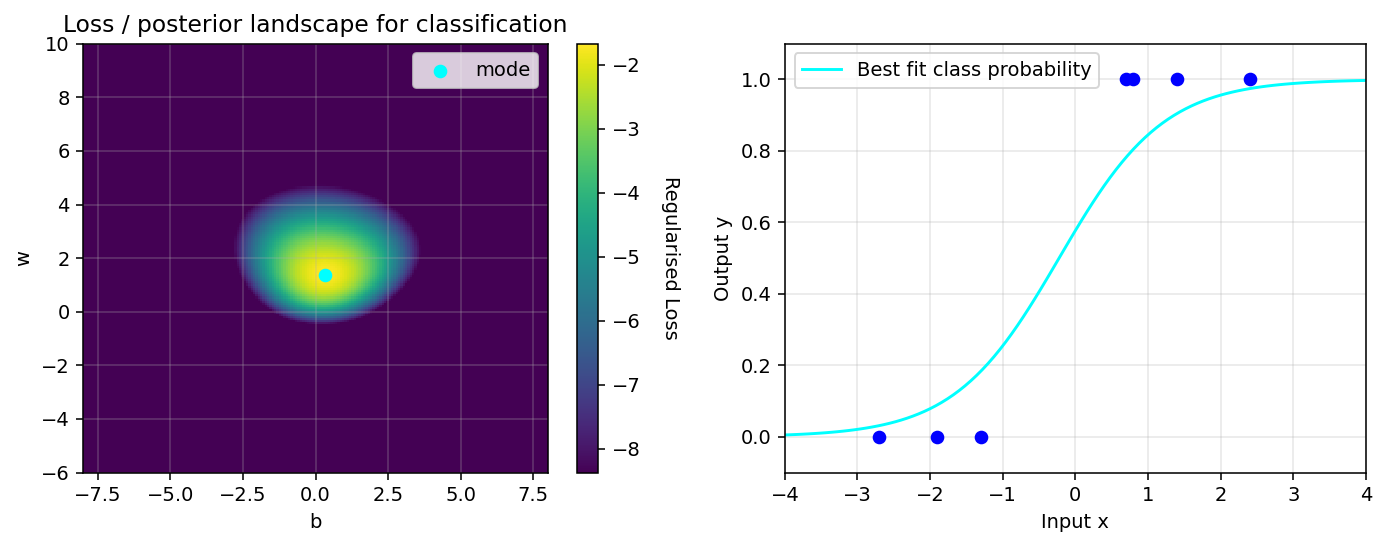

In [76]:
#@title Plotting the loss landscape and finding the solution at the mode
#@markdown Nottice that the loss is non-symmetric around its mode

alpha = 0.75


def generate_loss_fun():
  def loss_fun(w):
    return logistic_regression_loss(X=affine_basis(x_data_list_classification),
                    y=y_data_list_classification, vmap_model=vmap_linear, w=w, alpha=alpha)
  return loss_fun
loss_fun = generate_loss_fun()

x0_grid, x1_grid, loss_grid = generate_loss_grid(loss_fun=loss_fun, grid_size=200, lim0=[-8,8], lim1=[-6,10])



def gen_objective(X, y, vmap_model, alpha):
  def objective(params, key):
    return -logistic_regression_loss(X, y, vmap_model, params, alpha)
  return objective 

objective = gen_objective(affine_basis(x_data_list_classification),
                      y_data_list_classification, vmap_linear, alpha)

optimised_regularised_classification_params = optimise(objective, params=jnp.array([0.,0.]), \
                            plotting_func=None, LR=1e-2, MAX_STEPS=800, LOG_EVERY=100)


fig, ax = plt.subplots(1,2, dpi=140, figsize=(10,4))
mesh = ax[0].pcolormesh(x0_grid, x1_grid, -loss_grid, vmin=-loss_grid.min() * 5, vmax=-loss_grid.min(), cmap='viridis') # 
cbar = fig.colorbar(mesh, ax=ax[0])
cbar.set_label('Regularised Loss', rotation=270, labelpad=20)
ax[0].set_ylabel('w')
ax[0].set_xlabel('b')
ax[0].set_title('Loss / posterior landscape for classification')
ax[0].grid(alpha=0.3)
ax[0].scatter(optimised_regularised_classification_params[0], optimised_regularised_classification_params[1], c='cyan', label='mode')
ax[0].legend()


xlim = [-4,4]
ylim = [-0.1, 1.1]

x_pred = jnp.linspace(xlim[0], xlim[1], 101)


mode_predictions = sigmoid(vmap_linear(affine_basis(x_pred), optimised_regularised_classification_params))
ax[1].plot(x_pred, mode_predictions, c='cyan', label='Best fit class probability')
ax[1].grid(alpha=0.3)
ax[1].legend()
ax[1].plot(x_data_list_classification, y_data_list_classification, "ob")
ax[1].set(xlabel="Input x", ylabel="Output y",
      xlim=xlim, ylim=ylim)
plt.tight_layout()
plt.show()


**Group task  <font color='green'>`Base`</font>** - Discuss with a neighbour and / or tutor:

* Is the loss quadratic? Is the loss convex?

* What is the cause of the posterior being wider for larger values of $w$?

* When normalised, will the posterior be Gaussian?

* Nottice that the Gaussian posterior contours from the previous section are symmetric around their mode. Is this loss landscape symmmetric around its mode? What do you think would be the implications of approximating this posterior distribution with a Gaussian.


In [77]:
#@title Takeaways for this section (reveal after discussion above):

print("-- Outside of the linear-Gaussian regresion case, the loss function is usually non quadratic. This is the case for logistic regression.\n")

print("-- When the loss is non-quadratic, the posterior is non-Gaussian. \n")

print("-- Usually, we do not have closed form \"pen and paper\" expressions for non-Gaussian posterior distributions \n and we need to resort to approximations.\n")

print("-- If we approximate a non-Gaussian posterior with a Gaussian, we will be placing excess posterior probability density \nin some regions of parameter space and not enough density in other regions. In the next sections we will see what effect this has on performance.")

-- Outside of the linear-Gaussian regresion case, the loss function is usually non quadratic. This is the case for logistic regression.

-- When the loss is non-quadratic, the posterior is non-Gaussian. 

-- Usually, we do not have closed form "pen and paper" expressions for non-Gaussian posterior distributions 
 and we need to resort to approximations.

-- If we approximate a non-Gaussian posterior with a Gaussian, we will be placing excess posterior probability density 
in some regions of parameter space and not enough density in other regions. In the next sections we will see what effect this has on performance.


# Section 3: Black Box Variational Inference <a name="S3"></a>

This section implemented Black Box Variational Inference. It is the crux of the prac and you should spend up to 30 minutes on it.

The logistic regression posterior is non-quadratic and thus non-Gaussian. Even worse, we do not have a closed form expression for the posterior distribution. However, after [Section 1](#S1), we are very comfortable  working with Gaussians.

We are going to try to find the Gaussian which is closest to the logistic regression posterior and use that one. We are going to call our Gaussian approximate distribution $q$. We will learn its mean and covariance parameters $\mu_q, \Sigma_q$: $q(\color{blue}{\underline{w}}) = \mathcal{N}(\color{blue}{\underline{w}}; \mu_q, \Sigma_q)$

But, what do we mean by "closest"? We need to choose a notion of distance between distributions. We are going to choose the [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence). That is, we want to minimise the KL divergence between our approximation $q(\color{blue}{\underline{w}})$ and the true posterior $p(\color{blue}{\underline{w}} | X, \underline{y})$ which we write as $\text{KL}(q(\color{blue}{\underline{w}}) \, ||\, p(\color{blue}{\underline{w}} | X, \underline{y}))$. This quantity takes a minimum value of 0 which is only reached when $q(\color{blue}{\underline{w}}) = p(\color{blue}{\underline{w}} | X, \underline{y})$. 



## Introducing the ELBO

We dont know the anaylitical form of $p(\color{blue}{\underline{w}} | X, \underline{y})$, so how do we minimise $\text{KL}(q(\color{blue}{\underline{w}}) \, ||\, p(\color{blue}{\underline{w}} | X, \underline{y}))$?

We are going to use a trick called the **Evidence Lower BOund (ELBO)**. Specifically, we are going to derive that maximising the objective 

<center>
$\text{ELBO} = \mathbb{E}_{q(\color{blue}{\underline{w}})}[\log p(\underline{y} | X, \color{blue}{\underline{w}})]$ - $\text{KL}(q(\color{blue}{\underline{w}}) \, ||\, p(\color{blue}{\underline{w}}))$
</center>

is equivalent to minimising $\text{KL}(q(\color{blue}{\underline{w}}) \, ||\, p(\color{blue}{\underline{w}} | X, \underline{y}))$. This is great because the ELBO does not contain the posterior anymore, only the likelihood $p(\underline{y} | X, \color{blue}{\underline{w}})$ and prior $p(\color{blue}{\underline{w}})$!

**Math Task** (Optional) <font color='red'>`Advanced`</font>: Derive the ELBO


<center>
Show that minimising $\text{KL}(q(\color{blue}{\underline{w}}) \, ||\, p(\color{blue}{\underline{w}} | X, \underline{y}))$ is equivalent to maximising $\mathbb{E}_{q(\color{blue}{\underline{w}})}[\log p(\underline{y} | X, \color{blue}{\underline{w}})]$ - $\text{KL}(q(\color{blue}{\underline{w}}) \, ||\, p(\color{blue}{\underline{w}}))$
</center>

\
* Hint 1: The KL divergence can be written as $\text{KL}\left(q(a)\,||\,p(b)\right) = \mathbb{E}_{q(a)}[\log q(a) - \log p(b)]$. 

Use this together with decomposing the posterior using Bayes Rule: $p(\color{blue}{\underline{w}} | X, \underline{y}) = \frac{p(\underline{y} | X, \color{blue}{\underline{w}}) p(\color{blue}{\underline{w}})}{p(\underline{y} | X)}$

\
* Hint 2: The ELBO is called like that because it is a lower bound on the evidence: $\log p(\underline{y} | X)$. Try separating out this term, and notticing that it does not depend on $\color{blue}{\underline{w}}$ so that $\mathbb{E}_{q(\color{blue}{\underline{w}})}[\log p(\underline{y} | X)] = \log p(\underline{y} | X)$.

To set up the inequality $\log p(\underline{y} | X) \geq ...$ you can use [Jensen's](https://en.wikipedia.org/wiki/Jensen%27s_inequality) inquality: $\quad \log \mathbb{E}[p] \geq  \mathbb{E}[\log p]$.




In [78]:

# @title Answer to math task (Try not to run until you've given it a good try!') 
from IPython.display import display, Markdown, Latex

display("Solution Derivation")
display(Latex("$\\text{KL}(q(\\underline{w}) \, ||\, p(\\underline{w} | X, \\underline{y})) = \\mathbb{E}_{q(\\underline{w})}[\\log q(\\underline{w}) - \\log p(\\underline{w} | X, \\underline{y})] = \mathbb{E}_{q(\\underline{w})}[\\log q(\\underline{w}) - \\log \\frac{p(\\underline{y} | X, \\underline{w}) p(\\underline{w})}{p(\\underline{y} | X)}]$"))


display(Latex("$ = \\mathbb{E}_{q(\\underline{w})}[\\log q(\\underline{w}) - \\log p(\\underline{y} | X, \\underline{w}) - \\log p(\\underline{w}) +  \\log p(\\underline{y} | X)]$"))
display(Latex("$ = \\mathbb{E}_{q(\\underline{w})}[- \\log p(\\underline{y} | X, \\underline{w})] +  \\mathbb{E}_{q(\\underline{w})}[ \\log q(\\underline{w})  - \\log p(\\underline{w})] +  \\log p(\\underline{y} | X)$"))
display(Latex("$ = - \\mathbb{E}_{q(\\underline{w})}[\\log p(\\underline{y} | X, \\underline{w})] + \\text{KL}\\left(\\log q(\\underline{w}) \,||\, \\log p(\\underline{w})\\right) +  \\log p(\\underline{y} | X)$"))


display("Thus")
display(Latex("$\\log p(\\underline{y} | X) - \\text{KL}\\left(q(\\underline{w}) \, ||\, p(\\underline{w} | X, \\underline{y})\\right) = \\mathbb{E}_{q(\\underline{w})}[\\log p(\\underline{y} | X, \\underline{w})] - \\text{KL}\\left(\\log q(\\underline{w}) \,||\, \\log p(\\underline{w})\\right) = \\text{ELBO}$"))

display("Since")
display(Latex("$\\log p(\\underline{y} | X)$"))
display("is constant and independent of q, then maximising the ELBO is equivalent to minimising")
display(Latex("$\\text{KL}\\left(q(\\underline{w}) \, ||\, p(\\underline{w} | X, \\underline{y})\\right)$"))

'Solution Derivation'

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

'Thus'

<IPython.core.display.Latex object>

'Since'

<IPython.core.display.Latex object>

'is constant and independent of q, then maximising the ELBO is equivalent to minimising'

<IPython.core.display.Latex object>

**Group task <font color='green'>`Base`</font>** - Discuss with a neighbour and / or tutor:

* When will the KL to the true posterior $\text{KL}(q(\color{blue}{\underline{w}}) \, ||\, p(\color{blue}{\underline{w}} | X, \underline{y}))$ be 0, if ever?

* What is the maximum value that the ELBO can take?

* Can one overfit by optimising the ELBO?

## Implementing the ELBO

Now we are going to implement an ELBO which we can apply to any model to perform Bayesian inference

Most of the code is written for you and you will just have to complete some bits.

### We are going to be learning a Gassuain $q(\color{blue}{\underline{w}}) = \mathcal{N}(\color{blue}{\underline{w}}; \mu_q, \Sigma_{q})$

In practise, that means that we need to learn the mean vector $\mu_q$ and a covariance matrix $\Sigma_q$. 

In [82]:
#@title Code to initialise parameters and construct the covariance matrix

#@markdown A property of covariance matrices is that they need to be [possitive definite](https://en.wikipedia.org/wiki/Definite_matrix)

#@markdown To ensure that is always true, we are going to parametrise the covariance as $\Sigma_{q} = (L_o + \sigma I) (L_o + \sigma I)^T$ where $L$ is a lower triangular matrix

#@markdown **code review task** <font color='green'>`Base`</font>: read through this code to convince yourself it computes the covariance as described

def initialize_params(D, key=random.PRNGKey(0)):
    """
    Return randomly initialised parameters of the variational posterior q
    """
    dist_mean = normal(stddev=1)
    dist_cov = normal(stddev=1e-3)
    keys = random.split(key, 5)
    
    params = {}
    params['w'] = dist_mean(keys[0], (D,)) 
    params['L_o'] = jnp.tril(dist_cov(keys[1], (D, D)), -1) 
    params['sig'] = dist_cov(keys[2], (D,)) 
    return params

@jit
def get_L(params, min_diag=1e-6):
    """
    Construct square root of covariance matrix as L_o + \sigma I
    """
    log_diag = params['sig']
    off_diag = params['L_o']
    sig_diag =  jnp.diag(jnp.clip( jnp.exp(log_diag), a_min=min_diag))
    tril_L = jnp.tril(off_diag, -1)
    L = tril_L + sig_diag
    return L

@jit
def get_Sig(params, min_diag=1e-6):
    """
    Construct covariance matrix as (L + \sigma I)(L + \sigma I)^T
    """
    L = get_L(params, min_diag=min_diag)
    return jnp.matmul(L, L.T)
                

    


In [81]:
#@markdown We are going to compute the expectation ${E}_{q(\color{blue}{\underline{w}})}[\log p(\underline{y} | X, \color{blue}{\underline{w}})]$ with Monte Carlo. For that we need to draw samples from $q$.

#@markdown To sample from $\mathcal{N}(\mu_q, \Sigma_{q})$, we are going to use a trick to turn samples from $\mathcal{N}(0, I)$ into samples from q.

#@markdown Specifically, we will do $\mu_q + (L + \sigma I) \epsilon\,\,$   with $\epsilon \sim \mathcal{N}(0, I)$

#@markdown **code review task** <font color='green'>`Base`</font>: read through this code to verify it draws samples as described

def sample_weights(params, key, Nsamples=100):
    """
    return a matrix of size (D, K) containing K samples from
     our variational distribution q
    """
    mu = params['w']
    L = get_L(params, min_diag=1e-6)
    eps = random.normal(key, shape=(mu.shape[0], Nsamples))
    w = mu + jnp.matmul(L, eps).T
    return w
    

In [80]:
#@title Implementation of KL divergence between Gaussians

#@markdown this code computes $\text{KL}(\mathcal{N}(\mu_q, \Sigma_q) \,||\, \mathcal{N}(0, \alpha^{-1}I))$

#@markdown In the interest of time, **you do not need to check this one** since we have not covered how to derive the expression.

#@markdown If you are curious, [Here](https://mr-easy.github.io/2020-04-16-kl-divergence-between-2-gaussian-distributions/) is a nice resource showing the derivation 

@jit
def rho_logdet(rho):
    return (2 * jnp.sum(rho).clip(a_min=-700))  # empirically -730 is close to torch log(0)

@jit
def KLD_cost(params, prior_log_std):
    """
    KL divergence between a full covariance Gaussian and an isotropic Gaussian

    Args:
      prior_log_std: scalar or vector of size D
    """

    q_mu = params['w']
    q_logdet = rho_logdet(params['sig'])
    q_Sig = get_Sig(params)
    
    d = q_Sig.shape[0]
    
    var_p = jnp.exp(2 * prior_log_std)
 
    Sig_p_inv = jnp.eye(d) * 1/var_p
    p_logdet = 2 * (prior_log_std * d).clip(a_min=-700)
     
    
    mu_sigma_inv_mu = q_mu @ Sig_p_inv @ q_mu
    logdet_ratio = p_logdet - q_logdet
    trace_term = jnp.trace(jnp.matmul(Sig_p_inv, q_Sig))
    
    KLD =  0.5 * (trace_term + mu_sigma_inv_mu - d + logdet_ratio)

    return KLD

In [85]:
#@title Implementation of log-likelihood functions
#@markdown These functions compute $\log p(\underline{y} | X, \color{blue}{\underline{w}})$ for the Gaussian and Bernouilli distributions respectively.

#@markdown Remember the equivalency between log-likelihoods and standard loss functions described in the previous sections.

#@markdown For regression, we are rellying on the scipy implementation. However, we might as well have written $-0.5||\underline y - X\color{blue}{\underline{w}}||^2_2$.

#@markdown For classification, we are rellying on the cross entropy loss.

@jit
def gaussian_ll(pred, y):
    z = (y-pred)
    return norm.logpdf(z, loc=0, scale=1)

def bernouilli_ll(pred, y):
  return -sigmoid_binary_cross_entropy(pred, y)



**Coding task**  <font color='green'>`Base`</font>: putting it all together -- Implement the ELBO

We have code to compute the KL term in the ELBO, we have code to sample from q and we have code to compute log-likelihoods $\log p(\underline{y} | X, \color{blue}{\underline{w}_s})$

You will implement $\mathbb{E}_{q(\color{blue}{\underline{w}})}[\log p(\underline{y} | X, \color{blue}{\underline{w}})]$ using a MonteCarlo estimator $\frac{1}{N_{\text{samples}}}\sum_{s=1}^{N_{\text{samples}}} \log p(\underline{y} | X, \color{blue}{\underline{w}_s})$ with $\color{blue}{\underline{w}_s} \sim q(\color{blue}{\underline{w}})$

* hint1: use the `sample_weights` method that was implemented in the cells above to draw samples. You can then push the samples through the `model` function to get predictions

* hint2: `ll_func` which is taken as an input takes `pred` and `y` as inputs and returns $\log p(\underline{y} | X, \color{blue}{\underline{w}_s})$

After this, the rest of the prac will just consist of running this code and studying how it behaves


In [ ]:

def gen_Gaussian_ELBO(model, alpha, ll_func, Nsamples=100):
    """
    Computes linear regression posterior parameters
    
    Args:
      model: vmap model that takes X and w as inputs
      alpha: scalar - regulasisation strength or prior precision
      ll_func: function that maps from predictions and targets to log densities
      Nsamples: integer, how many samples to draw for MonteCarlo estimator
    Returns:
      
      Gaussian_ELBO: function which we can evaluate at our data points
       and returns the ELBO estimate
    """
    prior_log_std = - 0.5 * jnp.log(alpha)

    def ll_term(params, key, X, y):
        w = # Your code goes here. 
        predictions = # Your code goes here. 
        ll = # Your code goes here. 
        #You need to return ll, a matrix of size (Nobservations, Nsamples) 
        return ll.sum(axis=0).mean(axis=0) # sum over observations and average over samples

    def Gaussian_ELBO(params, key, X, y):
      KL = KLD_cost(params, prior_log_std)
      ll = ll_term(params, key, X, y)
      return ll - KL
    
    return jit(Gaussian_ELBO)




SyntaxError: ignored

In [86]:
# @title Run me to test your code

alpha = 1

Gaussian_ELBO = gen_Gaussian_ELBO(model=vmap_linear, alpha=alpha,
                                ll_func=gaussian_ll, Nsamples=1000)
key=random.PRNGKey(0)
params = initialize_params(D=2, key=key)
objective = jit(partial(Gaussian_ELBO, X=affine_basis(x_data_list_classification), y=y_data_list_classification))

ELBO_correct = -28.404984

assert jnp.abs(objective(params, key) - ELBO_correct) < 1e-3, "Covariance is not calculated correctly"

print('It seems correct. Look at the answer below to compare methods.')

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:4506: FutureWarning: `a_min` and `a_max` keyword arguments to ndarray.clip are deprecated in favor of `min` and `max` for compatibility with numpy. They will be removed in JAX 0.22.2
  'They will be removed in JAX 0.22.2', FutureWarning)


It seems correct. Look at the answer below to compare methods.


In [83]:
# @title Answer  (Try not to peek until you've given it a good try!') 


def gen_Gaussian_ELBO(model, alpha, ll_func, Nsamples=100):
    """
    Computes linear regression posterior parameters
    
    Args:
      model: vmap model that takes X and w as inputs
      alpha: scalar - regulasisation strength or prior precision
      ll_func: function that maps from predictions and targets to log densities
      Nsamples: integer, how many samples to draw for MonteCarlo estimator
    Returns:
      
      Gaussian_ELBO: function which we can evaluate at our data points and returns the ELBO estimate
    """
    prior_log_std = - 0.5 * jnp.log(alpha)

    def ll_term(params, key, X, y):
        w = sample_weights(params, key, Nsamples)
        predictions = model(X, w.T,)
        ll = ll_func(predictions, y[:, None])
        return ll.sum(axis=0).mean(axis=0) # sum over observations and average over samples

    def Gaussian_ELBO(params, key, X, y):
      KL = KLD_cost(params, prior_log_std)
      ll = ll_term(params, key, X, y)
      return ll - KL
    
    return jit(Gaussian_ELBO)




## Lets recover the linear regression exact posterior with variational inference

First lets run a sanity check: we are going to run our black box variational inference algorithm on our linear regression problem. Since the true posterior is Gaussian, our Gaussian approximation $q$ should be able to recover it exactly.

This will allow us to verify that our implementation does not have bugs!

In [91]:
#@title Re-compute the linear reression true posterior and loss surface as a reference -- run this cell but there is no need to look at the code

alpha = 3

mu, covariance = BLR_posterior(affine_basis(x_data_list_outlier), y_data_list_outlier, alpha)

def generate_loss_fun():
  def loss_fun(w):
    return regularised_linear_regression_loss(X=affine_basis(x_data_list_outlier),
                    y=y_data_list_outlier, w=w, vmap_model=vmap_linear, alpha=alpha)
  return loss_fun
loss_fun = generate_loss_fun()

x0_grid, x1_grid, loss_grid = generate_loss_grid(loss_fun=loss_fun, grid_size=200, lim0=[-8,8], lim1=[-8,8])



In [92]:
#@title Plotting function for optimisation -- run this cell but there is no need to look at the code

def gen_plots(params):

    q_covariance = get_Sig(params, min_diag=1e-6)
    q_mu = params['w']

    fig, ax = plt.subplots(1, 2, dpi=180, figsize = (10, 4))

    loss_landscape = ax[0].pcolormesh(x0_grid, x1_grid, -loss_grid,
                              vmin=-loss_grid.min() * 5, vmax=-loss_grid.min(),
                              cmap='viridis') # 
    plot_log_gaussian_ellipse(ax=ax[0], mean=mu, cov=covariance,
                              color='r', alpha=1, lw=1, label='exact posterior',
                              MAP_size=25, std_levels=[1, 2, 4, 6])
    plot_log_gaussian_ellipse(ax=ax[0], mean=q_mu, cov=q_covariance,
                              color='cyan', alpha=1, lw=1, label='variational posterior',
                              MAP_size=25, std_levels=[1, 2, 4, 6])
    
    cbar = fig.colorbar(loss_landscape, ax=ax[0])
    cbar.set_label('Regularised Loss', rotation=270, labelpad=20)
    ax[0].set_ylabel('w')
    ax[0].set_xlabel('b')
    ax[0].grid(alpha=0.3)
    ax[0].legend()
    ax[0].set_ylim([-8,8])
    ax[0].set_xlim([-8,8])
    ax[0].set_title('comparing posteriors in weight space')

    # Plot posterior predictive

    x_pred = jnp.linspace(-4,4, 201)
    X_pred = affine_basis(x_pred)

    xlim = [jnp.min(x_data_list_outlier)-1, jnp.max(x_data_list_outlier)+1]
    ylim = [jnp.min(y_data_list_outlier)-1, jnp.max(y_data_list_outlier)+1]

    predictive_mean, predictive_std = BLR_predictions(X_pred, mu, covariance)
    q_predictive_mean, q_predictive_std = BLR_predictions(X_pred, q_mu, q_covariance)

    errorfill(x_pred, predictive_mean, predictive_std, color='red', alpha_fill=0.2, line_alpha=1, ax=ax[1],
                  lw=2, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='exact predictive posterior', markevery=None)
    
    errorfill(x_pred, q_predictive_mean, q_predictive_std, color='cyan', alpha_fill=0.2, line_alpha=1, ax=ax[1],
                  lw=2, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='variational predictive posterior', markevery=None)


    ax[1].plot(x_data_list_outlier, y_data_list_outlier, "ob")
    ax[1].set(xlabel="Input x", ylabel="Output y",
          xlim=xlim, ylim=ylim)
    ax[1].grid(alpha=0.3)
    ax[1].legend()
    ax[1].set_title('comparing posteriors in funciton space')

    plt.tight_layout()



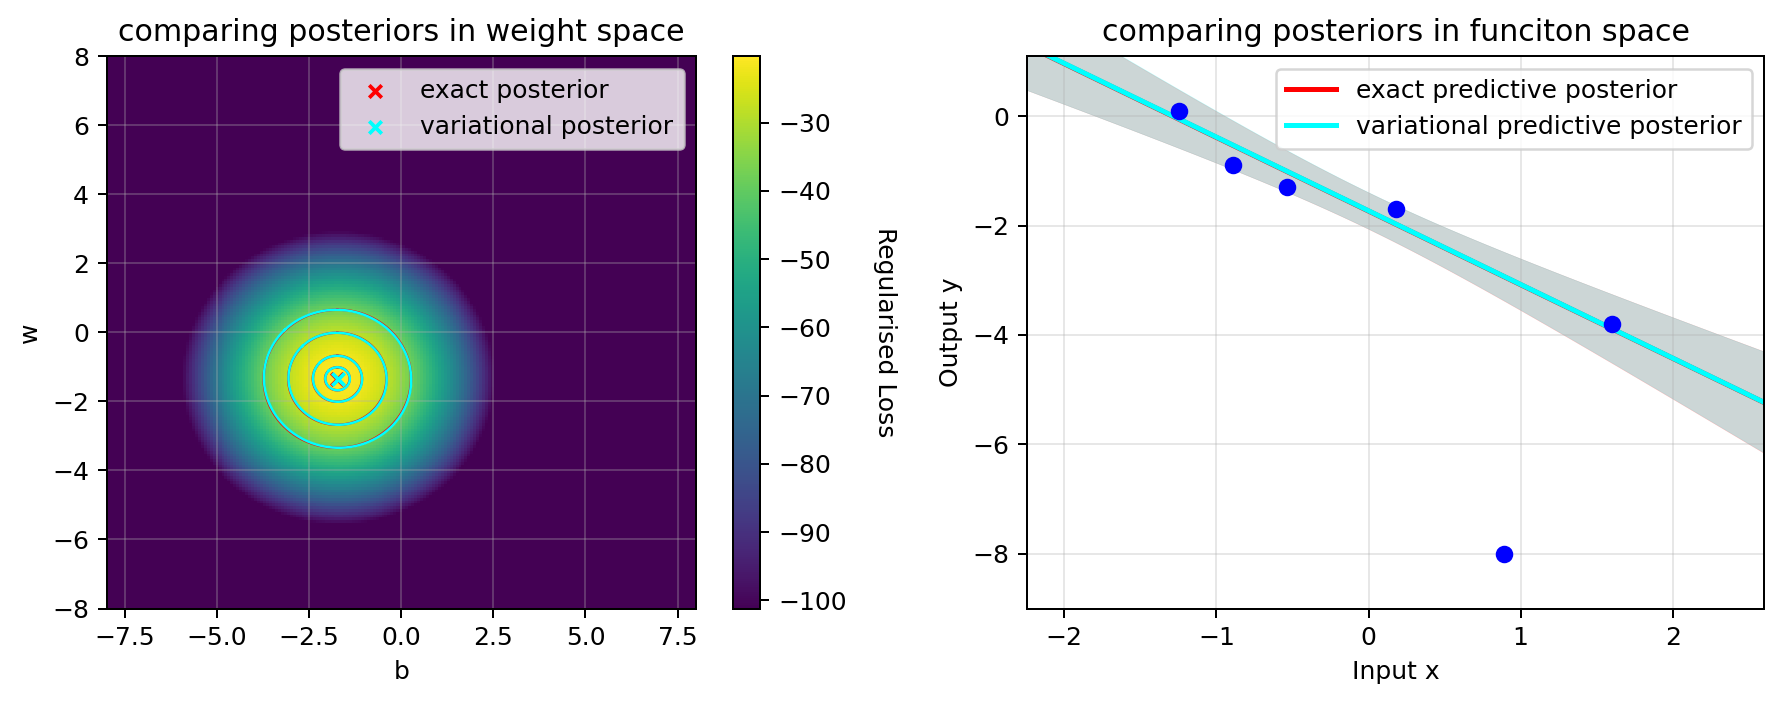

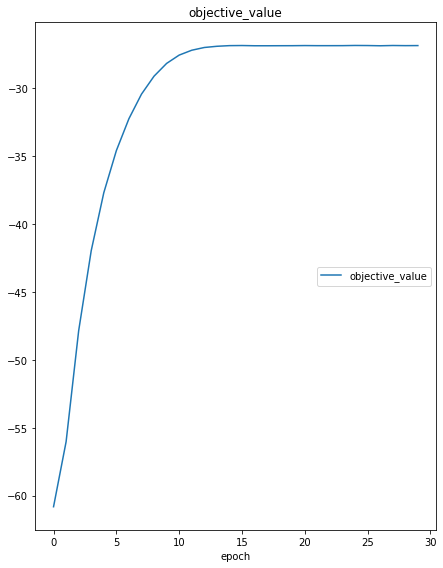

objective_value
	objective_value  	 (min:  -60.818, max:  -26.841, cur:  -26.849)


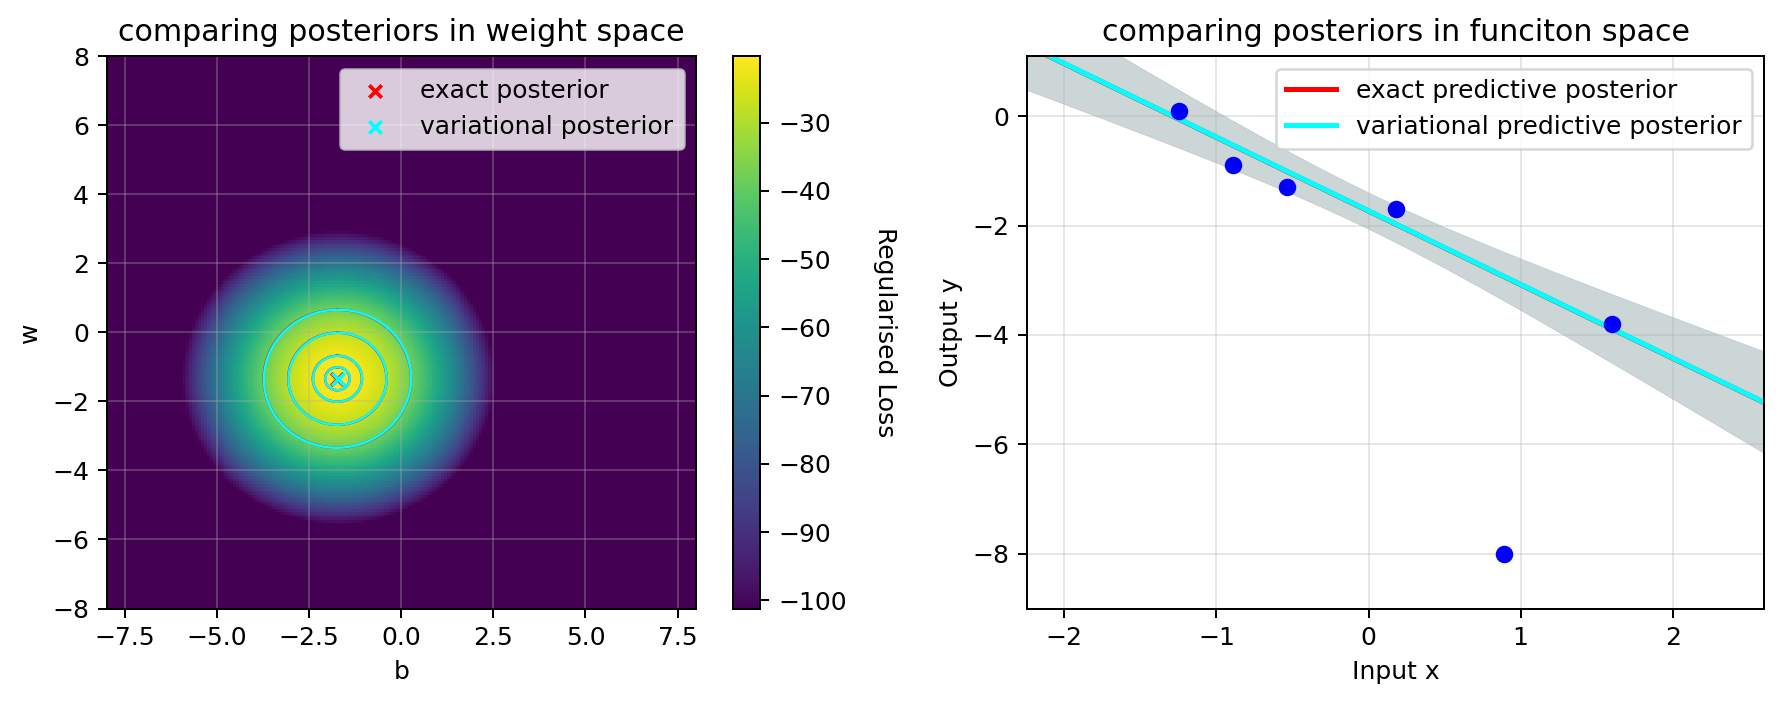

In [93]:
#@title Run me to train variational distribution on linear regression task



Gaussian_ELBO = gen_Gaussian_ELBO(model=vmap_linear, alpha=alpha,
                                ll_func=gaussian_ll, Nsamples=1000)


params = initialize_params(D=2, key=random.PRNGKey(0))

objective = jit(partial(Gaussian_ELBO, X=affine_basis(x_data_list_outlier), y=y_data_list_outlier))


optimised_regularised_params = optimise(objective, params=params, \
                            plotting_func=gen_plots, LR=5e-3, MAX_STEPS=1500, LOG_EVERY=50)



      


**Group task** <font color='green'>`Base`</font> - Discuss with a neighbour and / or tutor:

* Under what conditions does our variational inference algorithm recover the true posterior, i.e. $q(\color{blue}{\underline{w}})= p(\color{blue}{\underline{w}} | X, \underline{y})$? Did we recover the exact posterior here?

* Do you think we can overfit with this variational inference algorithm? Why?





## Lets approximate the Logistic regression posterior with variational inference

Now that we have verified that our black box variational inference algorithm does the right thing, lets try to apply it for the logistic regression problem.

Remember from [Section 2](#S2) that in logistic regression we are targettting a non-Gaussian posterior that is proportional to 

<center>
$p(\underline{y} | X, \color{blue}{\underline{w}}) p(\color{blue}{\underline{w}})  =  \prod_{n=1}^N Bern(y_n ; \phi(x_n \color{blue}{\underline{w}})) \mathcal{N}(\color{blue}{\underline{w}}; 0, \alpha^{-1} I)$
</center>

Lets run our same variational inference algorithm and see how it performs

In [94]:
#@title pre-compute loss surface and make plotting function -- run this cell but there is no need to look at the code

alpha = 0.75


def generate_loss_fun():
  def loss_fun(w):
    return logistic_regression_loss(X=affine_basis(x_data_list_classification),
                    y=y_data_list_classification, vmap_model=vmap_linear, w=w, alpha=alpha)
  return loss_fun
loss_fun = generate_loss_fun()

x0_grid, x1_grid, loss_grid = generate_loss_grid(loss_fun=loss_fun, grid_size=200, lim0=[-8,8], lim1=[-6,10])


def gen_plots(params):

    # Plot loss landscape and variational distribution
      q_covariance = get_Sig(params, min_diag=1e-6)
      q_mu = params['w']


      x_pred = np.linspace(-4, 4, 100)
      X_pred = affine_basis(x_pred)


      Nsamples = 20
      q_parameter_samples = jax.random.multivariate_normal(key, q_mu,  q_covariance, shape=(Nsamples,))
      q_sample_preds = vmap_linear(X_pred, q_parameter_samples.T)
      q_prob_samples = jax.nn.sigmoid(q_sample_preds)

      fig, ax = plt.subplots(1, 2, dpi=160, figsize=(10,4))

      loss_landscape = ax[0].pcolormesh(x0_grid, x1_grid, -loss_grid,
                                vmin=-loss_grid.min() * 10, vmax=-loss_grid.min(),
                                cmap='viridis') # 

      plot_log_gaussian_ellipse(ax=ax[0], mean=q_mu, cov=q_covariance,
                                color='cyan', alpha=1, lw=1, label='variational posterior',
                                MAP_size=25, std_levels=[1, 2, 4, 6])
      
      ax[0].scatter(q_parameter_samples[:,0], q_parameter_samples[:,1], 5, c='cyan', label='samples')
      cbar = fig.colorbar(loss_landscape, ax=ax[0])
      cbar.set_label('Regularised Loss', rotation=270, labelpad=20)
      ax[0].set_ylabel('w')
      ax[0].set_xlabel('b')
      ax[0].grid(alpha=0.3)
      ax[0].legend()
      ax[0].set_ylim([-6,10])
      ax[0].set_xlim([-8,8])
      ax[0].set_title('evaluating variational Bayesian posterior \n in weight space')


      for i, sample in enumerate(q_prob_samples.T):
        if i == 0:
          ax[1].plot(x_pred, sample, "-", color='cyan', lw=0.4, alpha=0.4, label='sample class probability')
        ax[1].plot(x_pred, sample, "-", color='cyan', lw=0.4, alpha=0.4)
      
      ax[1].plot(x_pred, q_prob_samples.mean(axis=1), "--", color='cyan', lw=2, label='variational posterior class probabilities')

      mode_predictions = sigmoid(vmap_linear(affine_basis(x_pred), optimised_regularised_classification_params))
      ax[1].plot(x_pred, mode_predictions, c='red', label='optimised class probabilities')

      # Plot posterior predictive

      ax[1].plot(x_data_list_classification, y_data_list_classification, "ob")
      ax[1].set(xlabel="Input x", ylabel="Output y",
            xlim=xlim, ylim=[-0.1, 1.1])
      ax[1].grid(alpha=0.3)
      ax[1].legend()
      ax[1].set_title('comparing regularised solution and \n variational Bayesian solution in function space')

      plt.tight_layout()




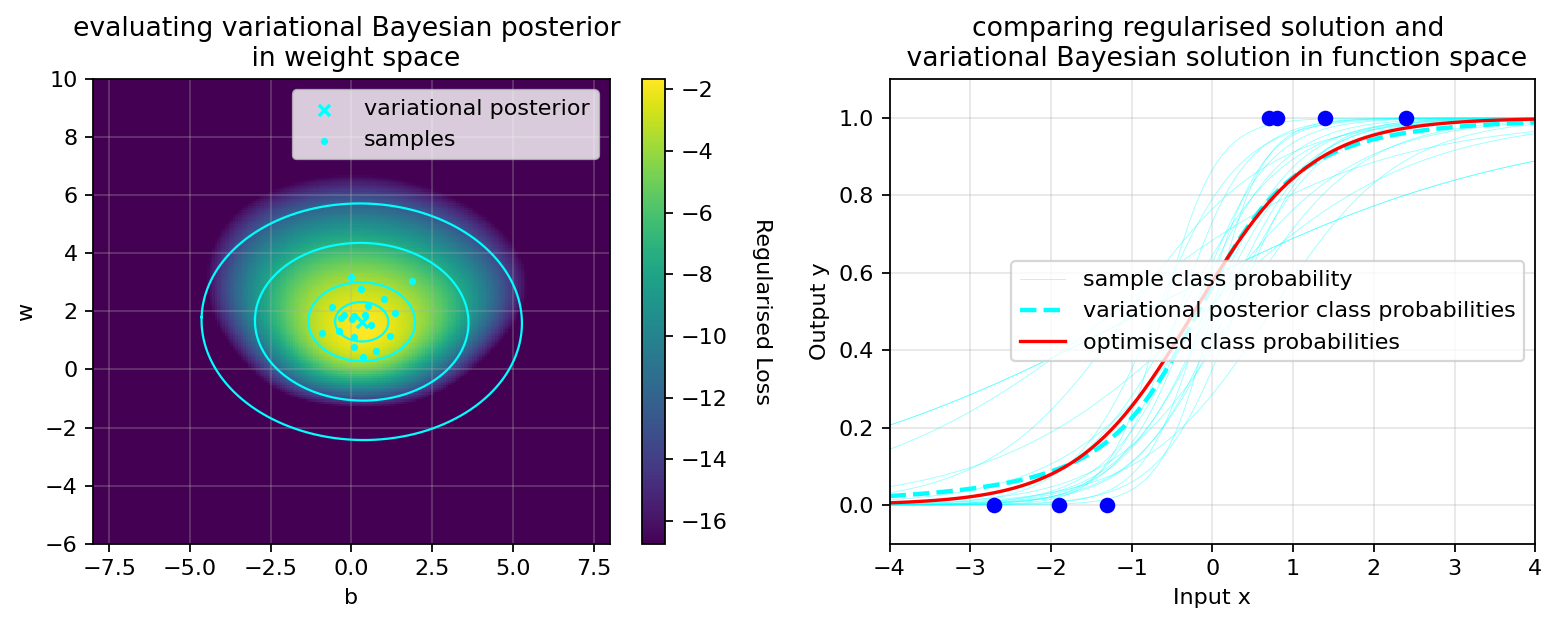

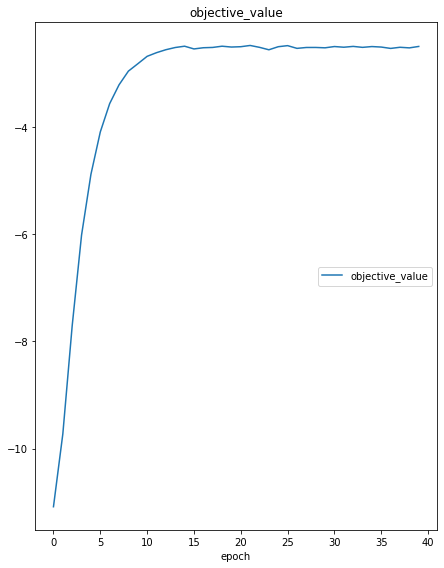

objective_value
	objective_value  	 (min:  -11.085, max:   -2.481, cur:   -2.499)


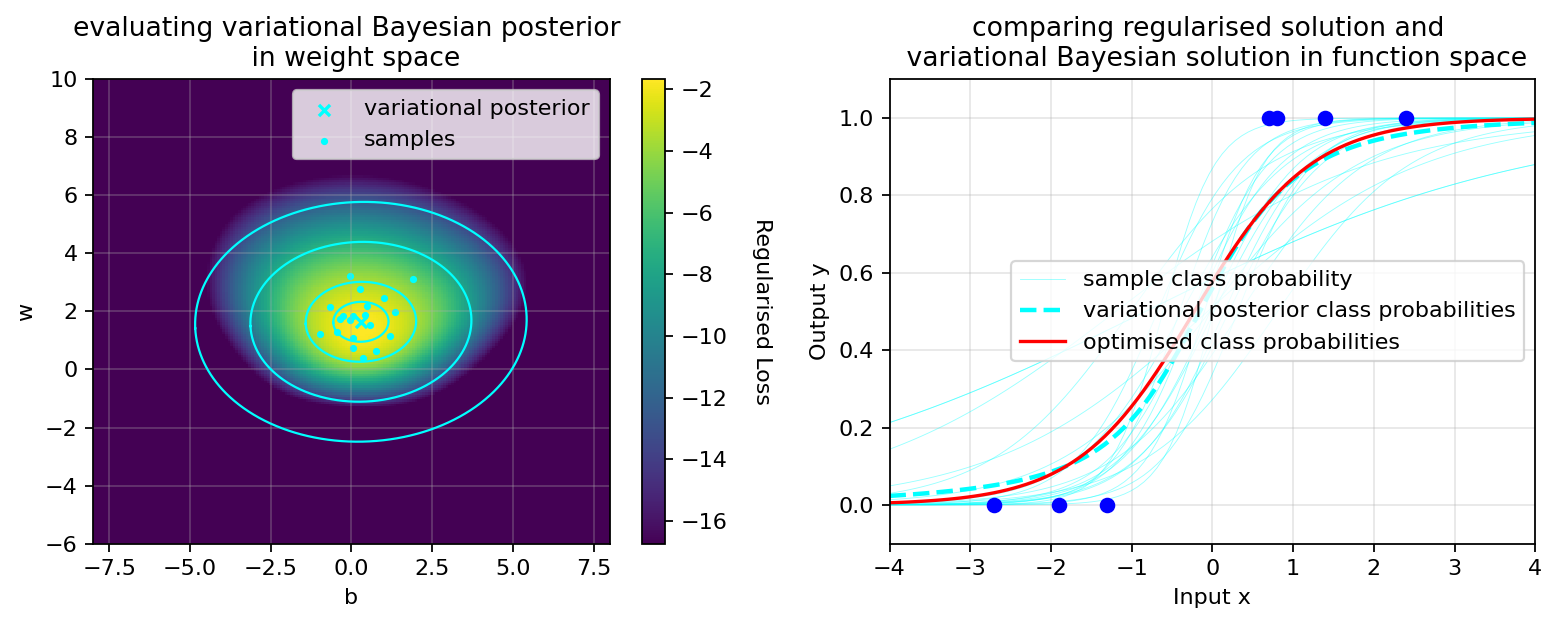

In [95]:
#@title Run me to train variational distribution on logistic regression task



Gaussian_ELBO = gen_Gaussian_ELBO(model=vmap_linear, alpha=alpha,
                                ll_func=bernouilli_ll, Nsamples=100) # Nottice we use the bernoulli likelihood now


params = initialize_params(D=2, key=random.PRNGKey(0))

objective = jit(partial(Gaussian_ELBO, X=affine_basis(x_data_list_classification), y=y_data_list_classification))


optimised_regularised_params = optimise(objective, params=params, \
                            plotting_func=gen_plots, LR=5e-3, MAX_STEPS=2000, LOG_EVERY=50)



**Group task** <font color='green'>`Base`</font> - Discuss with a neighbour and / or tutor:

* How many parameters are we learning when we perform variational inference?

* Are we reaching exact posterior in the logistic regression case?

* What are potential drawbacks of our variational inference algorithm?

* How does the variational posterior predictive class probability compare with the regularised optimisation solution? Is it more or less confident?

* Do all the samples represent reasonable solutions? If not, why?

## Takeaways

* We have implemented black box variational inference using a Gaussian variationa posterior. This algorithm allows us to **approximate any model's posterior** distribution with a Gaussian variational posterior, thus the name ''black box''.

* When the true posterior is Gaussian, our variational distribution will recover it exactly. When the true posterior is not Gaussian, then our variational distribution will choose the closest Gaussian in a KL divergence sense.

* Since our optimisation is minimising the KL divergence to the true posterior, optimising more can only get us closer to the true posterior. We can not overfit with variational inference. 

## End of Section

The rest of the section contains more advanced optional contents. You can skip to [Section 4](#S4) if you want.

**Group task** (Optional) <font color='orange'>`Intermediate`</font> - Discuss with a neighbour and / or tutor:

Remember that in the linear regression case we estimated both a predictive mean and predictive standard deviation from samples. In logistic regression, each sample provides us with a curve of class probability. We have computed the variational predictive mean class probability as the average of these probabilities and shown it with the dashed cyan line.

* Does it make sense to return standard deviation over samples like we did in the regression case? 

* How should we combine information from samples in logistic regression?


# Section 4: Bayesian Neural Networks <a name="S4"></a>

Now that we have our black-box VI algorithm coded up, its time to appy it to neural networks. We are going to see that when switching from linear and logistic regression to deep models, things become complicated fast.

This is the final core section of this prac. Spend as much time as you want on it but keep in mind that there is an additional optional section at the end where you can learnt about Hamiltonian Monte Carlo.

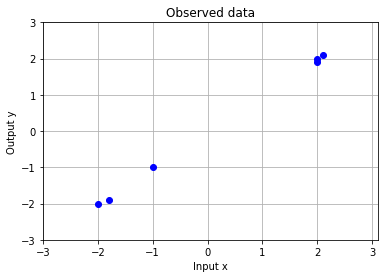

In [97]:
#@title Lets start with a very simple dataset, one that is very close to the indentity function $\,\,y=x$

x_data_list_identity = jnp.array([-2, -1.8, -1,  2, 2, 2.1]) 
y_data_list_identity = jnp.array([-2, -1.9, -1, 2, 1.9, 2.1]) 

plot_basic_data(x_data_list_identity, y_data_list_identity, ylim=[-3, 3])



In [98]:
#@title Lets start with a very basic NN
#@markdown Specifically, a 1 hidden layer, & 1 hidden unit NN with no non-linearity: $f(x, \color{blue}{\underline{w}}) = \color{blue}{\underline{w}_{1}} \color{blue}{\underline{w}_{0}} x$

#@markdown This model is linear in the inputs and weights. 


def NN(x, params):
  return  params[1] * params[0] * x

vmap_NN = jit(vmap(NN, in_axes=(0, None)))


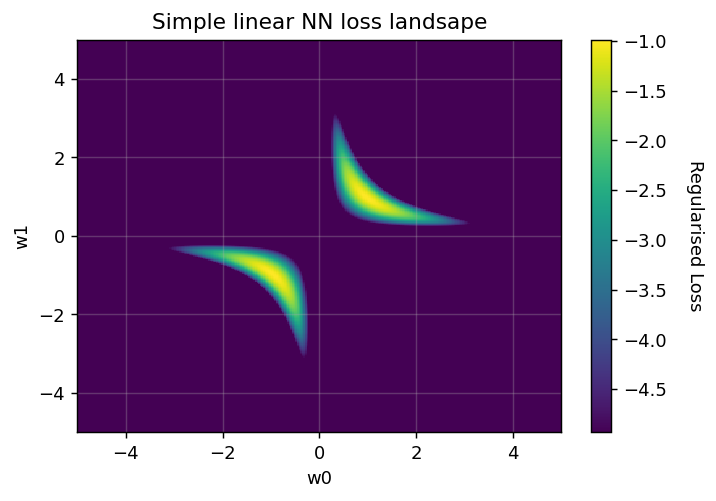

In [99]:
#@title ## Plot the loss landscape. It is non-convex. Its multimodal! 
#@markdown Even though we are trying to learn a simple identity function with a linear NN.

#@markdown This is due to the symmetries in the weight space between  $\color{blue}{\underline{w}_{1}}$ and $\color{blue}{\underline{w}_{0}}$. You can flip these weights around and obtain the same solution!


alpha=1


def generate_loss_fun():
  def loss_fun(w):
    return regularised_linear_regression_loss(X=x_data_list_identity,
                    y=y_data_list_identity, w=w, vmap_model=vmap_NN, alpha=alpha)
  return loss_fun

loss_fun = generate_loss_fun()

x0_grid, x1_grid, loss_grid = generate_loss_grid(loss_fun=loss_fun, grid_size=300, lim0=[-5,5], lim1=[-5,5])

fig = plt.figure(dpi=130)
loss_landscape = plt.pcolormesh(x0_grid, x1_grid, -loss_grid,
                          vmin=-loss_grid.min() * 5, vmax=-loss_grid.min(),
                          cmap='viridis') # 

plt.xlabel('w0')
plt.ylabel('w1')
ax = [plt.gca()]
cbar = fig.colorbar(loss_landscape, ax=ax[0])
cbar.set_label('Regularised Loss', rotation=270, labelpad=20)
plt.title('Simple linear NN loss landsape')
plt.grid(alpha=0.3)



## Our unimodal Gaussian approximation will struggle with the multimodal posterior but lets apply the black box variational inference algorithm anyway!

In [100]:
#@title define plotting method -- run this cell but there is no need to look at the code

def gen_plots(params):
    # Plot loss landscape and variational distribution
    q_covariance = get_Sig(params, min_diag=1e-6)
    q_mu = params['w']

    fig, ax = plt.subplots(1, 2, dpi=160, figsize=(10,4))

    loss_landscape = ax[0].pcolormesh(x0_grid, x1_grid, -loss_grid,
                              vmin=-loss_grid.min() * 5, vmax=-loss_grid.min(),
                              cmap='viridis') # 
    plot_log_gaussian_ellipse(ax=ax[0], mean=q_mu, cov=q_covariance,
                              color='cyan', alpha=1, lw=1, label='variational posterior',
                              MAP_size=25, std_levels=[1, 2, 4, 6])
    ax[0].set_ylabel('w')
    ax[0].set_xlabel('b')
    ax[0].grid(alpha=0.3)
    ax[0].legend()
    ax[0].set_ylim([-5,5])
    ax[0].set_xlim([-5,5])
    cbar = fig.colorbar(loss_landscape, ax=ax[0])
    cbar.set_label('Regularised Loss', rotation=270, labelpad=20)
    ax[0].set_title('variational distribution fit to true posterior')

    # Plot posterior predictive

    x_pred = np.linspace(-5, 5, 100)
    Nsamples = 20
    q_parameter_samples = jax.random.multivariate_normal(key, q_mu,  q_covariance, shape=(Nsamples,))
    q_sample_preds = vmap_NN(x_pred, q_parameter_samples.T)

    
    for i, sample in enumerate(q_sample_preds.T):
      if i == 0:
        ax[1].plot(x_pred, sample, "-", color='cyan', lw=0.4, alpha=1, label='sample predictions')
      ax[1].plot(x_pred, sample, "-", color='cyan', lw=0.4, alpha=1)
      
    errorfill(x_pred, q_sample_preds.mean(axis=1), q_sample_preds.std(axis=1), color='cyan', alpha_fill=0.2, line_alpha=1, ax=ax[1],
                  lw=2.5, linestyle='--', fill_linewidths=0.2, marker=None, markersize=1, label='preditive mean', markevery=None)


    ax[1].plot(x_data_list_identity, y_data_list_identity, "ob")
    ax[1].set(xlabel="Input x", ylabel="Output y",
          xlim=[-3,3], ylim=[-4,4])
    ax[1].grid(alpha=0.3)
    ax[1].set_title('Predictive posterior fit')
    ax[1].legend()

    plt.tight_layout()


KeyboardInterrupt: ignored

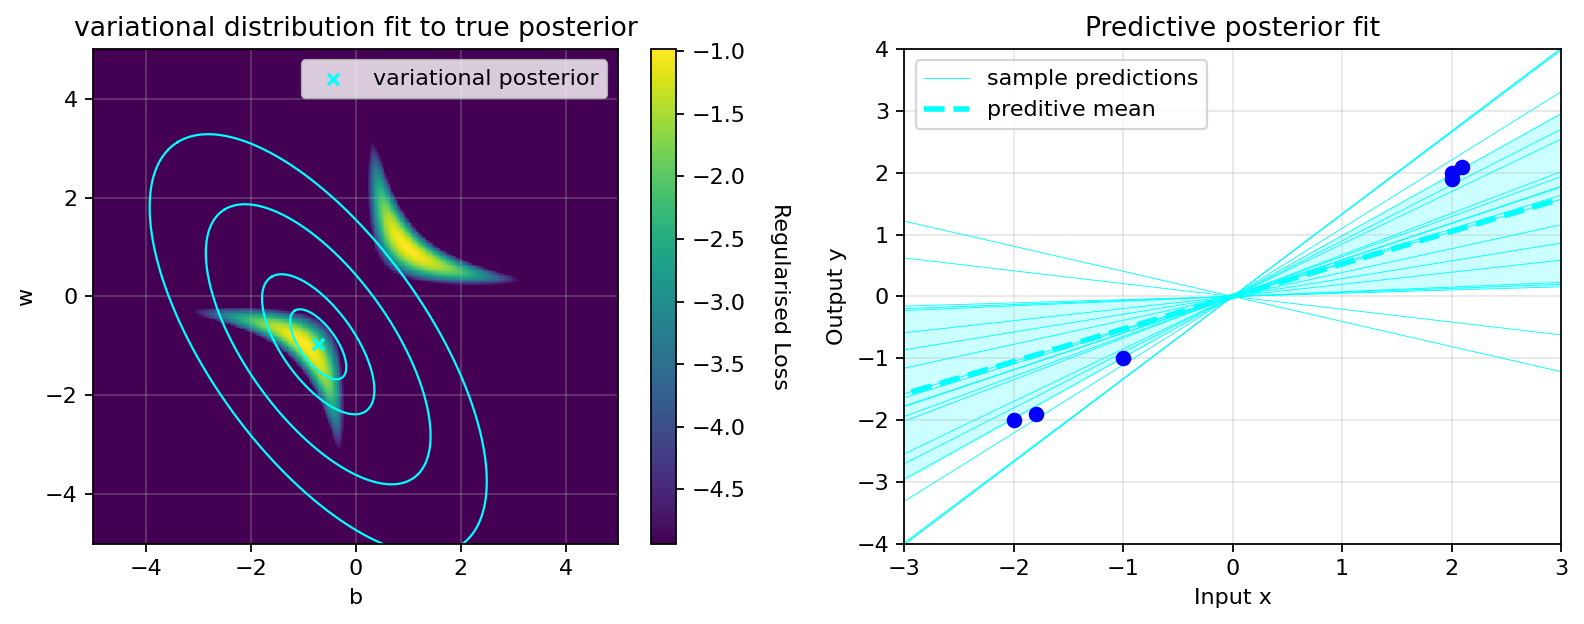

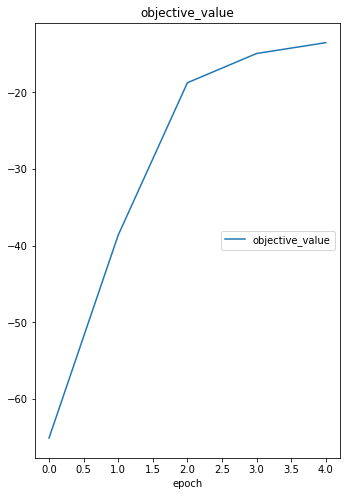

In [103]:
#@title **Plotting task** <font color='geen'>`Base`</font> Try setting `large_init` to both true and false and optimising the variational parameters. 
#@markdown What changes?

large_init = True # @param ['True', 'False'] {type:"raw"}

Gaussian_ELBO = gen_Gaussian_ELBO(model=vmap_NN, alpha=alpha,
                                ll_func=gaussian_ll, Nsamples=100)


params = initialize_params(D=2, key=random.PRNGKey(42))
if large_init:
  params['w'] = params['w'] * 5
  


objective = jit(partial(Gaussian_ELBO, X=x_data_list_identity, y=y_data_list_identity))


optimise(objective, params=params, \
            plotting_func=gen_plots, LR=5e-3, MAX_STEPS=2000, LOG_EVERY=50)





**Group task <font color='green'>`Base`</font>** - Discuss with a neighbour and / or tutor:

* What parameter settings, i.e. values of  $\color{blue}{\underline{w}_{1}}$ & $\color{blue}{\underline{w}_{0}}$ lead usto recover the identity function?

* Has your experimentation with the `large_init` option led you to discover a potential failure mode of our black box variational inference algorithm?

* When we do converge to one of the modes, does it matter which one we converge to? Are both the same?



## Exploring the limitations of Variational Inference for BNNs 


Now that we have seen a potential issue that can stem from multimodal loss landscapes, lets try a slightly more realistic example: a 4 parameter neural network complete with weights and biases. We will try to fit the same identity dataset.

In [104]:
#@title Our NN is now $f(x, \color{blue}{\underline{w}}) = \color{blue}{w_1} \text{ReLU}(\color{blue}{w_0} x + \color{blue}{b_0}) + \color{blue}{b_1}$

def NN(x, params):
  return  params[2] * jax.nn.relu(x * params[0] + params[1]) + params[3]

vmap_NN = jit(vmap(NN, in_axes=(0, None)))




In [105]:
#@title plot generation code -- run this cell but there is no need to look at the code

def gen_plots(params):
    # Plot loss landscape and variational distribution
    q_covariance = get_Sig(params, min_diag=1e-6)
    q_MAP = params['w']

    # Plot posterior predictive

    x_pred = np.linspace(-5, 5, 100)
    Nsamples = 20
    q_parameter_samples = jax.random.multivariate_normal(key, q_MAP,  q_covariance, shape=(Nsamples,))
    q_sample_preds = vmap_NN(x_pred, q_parameter_samples.T)

    plt.figure(dpi=120)
    
    ax = plt.gca()

    for i, sample in enumerate(q_sample_preds.T):
      if i == 0:
        ax.plot(x_pred, sample, "-", color='cyan', lw=0.4, alpha=1, label='sample predictions')
      ax.plot(x_pred, sample, "-", color='cyan', lw=0.4, alpha=1)
      
    errorfill(x_pred, q_sample_preds.mean(axis=1), q_sample_preds.std(axis=1), color='cyan', alpha_fill=0.2, line_alpha=1, ax=ax,
                  lw=2.5, linestyle='--', fill_linewidths=0.2, marker=None, markersize=1, label='preditive mean', markevery=None)


    ax.plot(x_data_list_identity, x_data_list_identity, "ob")
    ax.set_title('Predictive posterior fit')
    ax.set(xlabel="Input x", ylabel="Output y",
          xlim=[-3,3], ylim=[-4,4])
    plt.grid(alpha=0.3)
    plt.legend()

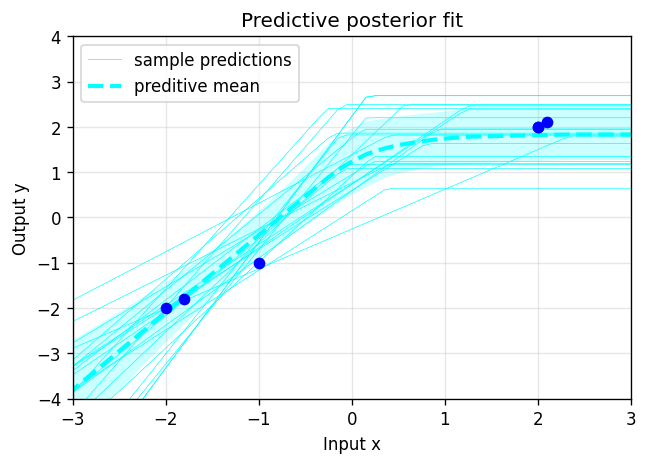

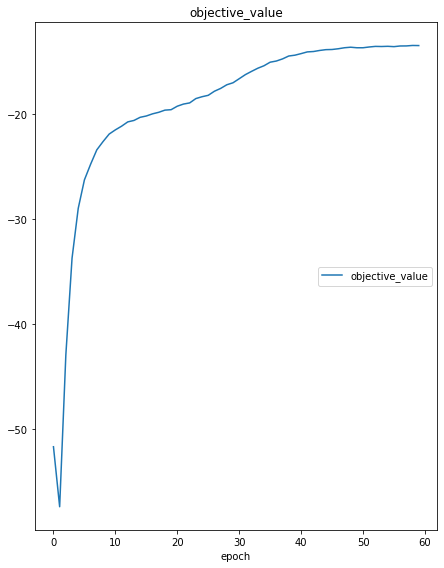

objective_value
	objective_value  	 (min:  -57.380, max:  -13.504, cur:  -13.514)


{'L_o': DeviceArray([[ 0.        ,  0.        ,  0.        ,  0.        ],
              [ 0.5450198 ,  0.        ,  0.        ,  0.        ],
              [-0.12657337,  0.21008606,  0.        ,  0.        ],
              [ 0.03917734,  0.2043404 , -0.36191773,  0.        ]],            dtype=float32),
 'sig': DeviceArray([-0.66172945, -0.25977838, -1.3177034 , -0.90081227], dtype=float32),
 'w': DeviceArray([-1.6197876 ,  0.16078562, -1.2483101 ,  1.7652187 ], dtype=float32)}

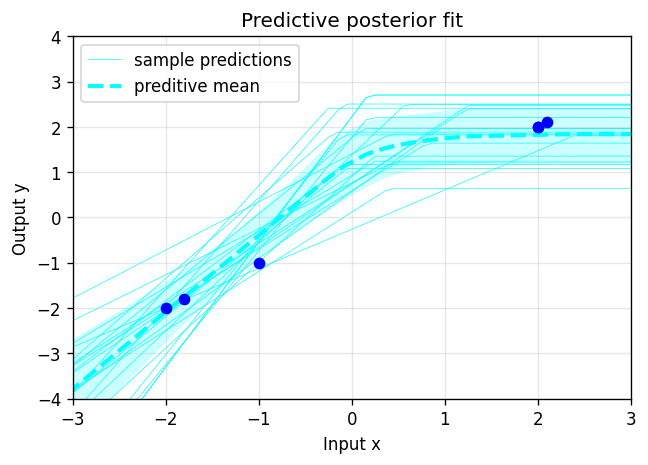

In [107]:
#@title **Plotting task**  <font color='green'>`Base`</font>: Optimise the variational parameters with different seeds
#@markdown We cant plot the loss landscape anymore because it is 4 dimensional. But we can always plot the predictive posterior

#@markdown Try using different seeds: 0 and 42

alpha=0.1

Gaussian_ELBO = gen_Gaussian_ELBO(model=vmap_NN, alpha=alpha,
                                ll_func=gaussian_ll, Nsamples=100)

Seed = 43 # @param {type:"integer"}

params = initialize_params(D=4, key=random.PRNGKey(Seed))  



objective = jit(partial(Gaussian_ELBO, X=x_data_list_identity, y=y_data_list_identity))

optimise(objective, params=params, \
            plotting_func=gen_plots, LR=2e-3, MAX_STEPS=3000, LOG_EVERY=50)




**Group task <font color='green'>`Base`</font>**: Discuss with a neighbour and / or tutor:

* How do the solutions found by the seeds 0 and 42 differ? What does this tell you about the loss landscape?

* Can you think up with a setting of the parameters ($b_0, w_0, b_1, w_1$) that recovers the identity?

* Why doesnt our optimiser find this configuration?

* Do the errorbars look reasonable?

* Do you think that our black box variational inference algorithm is a good tool for use with neural network models? How could it be improved? 
  * Hint: what if we averaged the solutions obtained with seeds 0 and 42?

## Takeaways

* Deep architectures result in multimodal loss functions and posteriors. This poses a challenge for our black box variational inference algorithm.

* Potential issues that may arise are: 
  1. the optimiser getting stuck in a local optima between modes where a lot of variational posterior mass is placed in high loss regions and thus we obtain a poor data fit.
  2. the optimiser identifying a mode of the loss that corresponds to an overly complicated solution that will not generalise: like fitting our "identity" dataset with an angled line.

## -- End of Prac --

The [next section](#S5) contains more advanced optional contents. You can skip to the [conclusions](#C) if you want.

# Section 5: Hamiltonian Monte Carlo (Optional) - <font color='orange'>`Intermediate`</font> <a name="S5"></a>

In the previous section, our Gaussian variational distribution was only able to identify individual modes of the posterior distribution and these often corresponded to poor predictions or poor errorbars.

Now, we will look at an approach for approximate Bayesian inference which is capable of working well even with multimodal posteriors: Hamiltonian Monte Carlo (HMC). This sampling method was introduced in [Radford Neal's thesis](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.446.9306&rep=rep1&type=pdf). HMC is designed to try to reach as many modes of the posterior as possible, giving an accurate approximation even for deep networks.
We will not cover the math behind this method in detail but we will explain how to use it. 

To use HMC, we just require access to an unnormalised posterior density, i.e. a loss function. As we saw in [Section 1](#S1), we already have this in the form of our regularised least squares objective: 

<center>
$\log \left( p(\underline{y} | X, \color{blue}{\underline{w}}) p(\color{blue}{\underline{w}}) \right) = \log \left( \mathcal{N}(\underline{y}; X\cdot \color{blue}{\underline{w}}, I) \mathcal{N}(\color{blue}{\underline{w}}; 0, \alpha^{-1} I)\right)= \frac{-1}{2}||\underline{y} - X\cdot \color{blue}{\underline{w}}||_{2}^2 + \frac{-\alpha}{2} ||\color{blue}{\underline{w}}||^2_2 + C$
</center>



As a Monte Carlo method, HMC will provide us with samples from the posterior $p(\color{blue}{\underline{w}} | X, \underline{y})$. We can then use these samples to estimate quantities of interest. In our case this will be the predictive mean and predictive standard deviation.


We are going to use [NumPyro](https://github.com/pyro-ppl/numpyro) an HMC library that works with jax.

In [108]:
#@title Here we define our numpyro model

#@markdown We specify a priors over our weights n with `numpyro.sample("w"...)` and the likelihood function `numpyro.sample(name="err"..., obs=err)`. The `obs` parameter states that we observe the targets, making this a likelihood funciton.

#@markdown Although HMC can work with the loss function directly, and numpyro supports this, it is more natural to specify our model in terms of prior and likelihood in numpyro.  

import numpyro
from numpyro.infer import MCMC, NUTS, init_to_value
import numpyro.distributions as dist


def NN_numpyro_model(y, X, D, model, alpha):
    w = numpyro.sample("w", dist.Normal(jnp.zeros(D), (alpha**-0.5)*jnp.ones(D)))
    preds = model(X, w)
    err = (y - preds )
    numpyro.sample(name="err", fn=dist.Normal(0, jnp.ones(len(y))), obs=err)
    


In [109]:
#@title Code to draw samples -- We use a standard configuraition

def draw_samples(model, warmup, n_samples, thinning, num_chains, init_dict={}, max_tree_depth=12):

    nuts_kernel = NUTS(model, forward_mode_differentiation=False, max_tree_depth=max_tree_depth, init_strategy=init_to_value(values=init_dict))
    mcmc = MCMC(nuts_kernel, num_warmup=warmup, num_samples=n_samples, thinning=thinning,
     num_chains=num_chains)
    rng_key = random.PRNGKey(0)

    mcmc.run(
        rng_key,
    )
    mcmc.print_summary()
    return mcmc.get_samples(group_by_chain=False)


alpha=0.05

sampling_model = partial(NN_numpyro_model, y=y_data_list_identity, X=x_data_list_identity, D=4, model=vmap_NN, alpha=alpha)
samples = draw_samples(sampling_model, warmup=5000, n_samples=5000, thinning=10, num_chains=1)



sample: 100%|██████████| 10000/10000 [00:12<00:00, 801.77it/s, 63 steps of size 1.10e-01. acc. prob=0.42]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      w[0]     -1.75      2.07     -0.86     -4.55     -0.16     16.55      1.00
      w[1]      0.80      2.22      0.26     -1.73      4.68     27.61      1.00
      w[2]     -2.32      1.49     -3.11     -3.97     -0.21      5.14      1.00
      w[3]      1.92      0.99      1.75      0.87      2.98     90.88      1.00

Number of divergences: 65


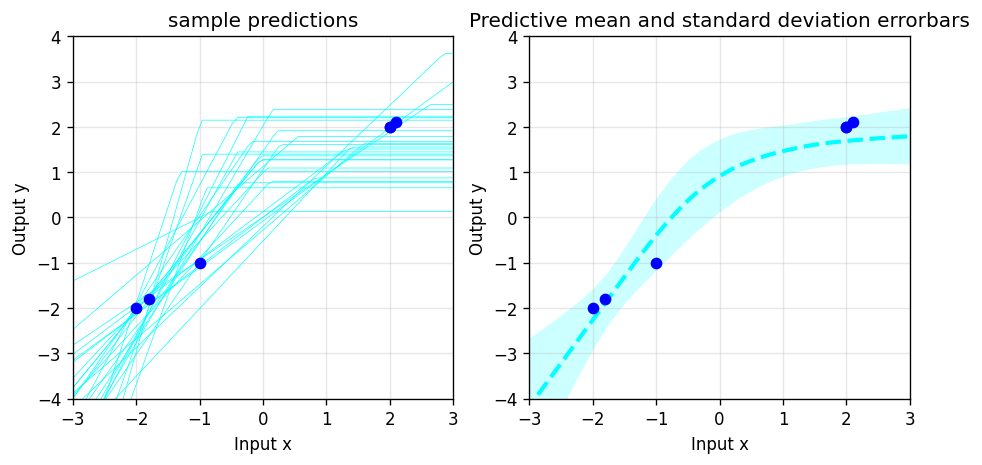

In [110]:
#@title Lets see the results

#@markdown We should get a much smoother regression line than with VI



sample_preds = vmap_NN(x_pred, samples['w'].T)

fig, ax = plt.subplots(1,2, dpi=120, figsize=(9, 4))



for i, sample in enumerate(sample_preds.T[::20]):
  if i == 0:
    ax[0].plot(x_pred, sample, "-", color='cyan', lw=0.4, alpha=1, label='sample predictions')
  ax[0].plot(x_pred, sample, "-", color='cyan', lw=0.4, alpha=1)
  

ax[0].plot(x_data_list_identity, x_data_list_identity, "ob")
ax[0].set_title('sample predictions')
ax[0].set(xlabel="Input x", ylabel="Output y",
      xlim=[-3,3], ylim=[-4,4])
ax[0].grid(alpha=0.3)

errorfill(x_pred, sample_preds.mean(axis=1), sample_preds.std(axis=1), color='cyan', alpha_fill=0.2, line_alpha=1, ax=ax[1],
              lw=2.5, linestyle='--', fill_linewidths=0.2, marker=None, markersize=1, label='preditive mean', markevery=None)


ax[1].plot(x_data_list_identity, x_data_list_identity, "ob")
ax[1].set_title('Predictive mean and standard deviation errorbars')
ax[1].set(xlabel="Input x", ylabel="Output y",
      xlim=[-3,3], ylim=[-4,4])
ax[1].grid(alpha=0.3)
# plt.legend()


**Group task <font color='orange'>`Intermediate`</font>**: Discuss with a neighbour and / or tutor:

* From the sample predictions, which modes has the sampler found? Has the sampler found all the modes we found with VI? Has the sampler found any new modes that VI failed to find?

* Do the errorbars look more or less reasonable than those obtained from our VI algorithm?

* How well do you think this method will scale to neural networks with more parameters, i.e. higher dimensional weight spaces?

## Takeaways

* HMC is a very powerful method that currently represents the state-of-the art for inference accuracy in neural networks. It has usage beyond inference in NNs however. It is a great tool to apply to any problem where we need to sample from multimodal unormalised distributions.

* However HMC is not perfect. It has serious limitations:
  1. It is not guaranteed to find every posterior mode. For instance, our HMC sampler failed to find the mode in which the function stays flat from -4 to 0 and then turns upward. This limitation gets worse in higher dimensions where different modes can be very far apart and are thus very hard to find.
  2. HMC is expensive to run. Specifically, HMC is a full batch method. For large datasets, each HMC step requires a full pass through the dataset. A standard HMC sampler delivers around 1 sample per 10 steps. This means that we need to make thousands of passes through our full dataset to get a couple hundred samples. This is not possible in modern settings. VI can be minibatched and thus does not suffer from this limitation.

* HMC is a more accurate but more expensive alternative to VI. Keep this in mind when choosing which algorithm to use for each task.



# Prac Conclusion <a name="C"></a>
**Summary:**

* Bayesian inference differs from traditional loss minimisation learning in that instead of retuning a single best parameter estimate, Bayesian inference returns every possible parameter setting weighed by how well these agree with the prior and the data.

* The disagreement among plausible parameter settings induces uncertainty in the predictions.

* Bayesian inference is hard because it requires characterising how well all parameter settings agree with the prior and data, i.e. characterising the posterior distribution. This is only possible to do analyticially in a very reduced range of models, such as the linear-Gaussian case.

* When the exact posterior is not tractable, we have to resort to approximations, such as variational inference or HMC. 

* Approximations present a tradeoff between fidelity and computational cost. VI is often cheaper but less accurate while HMC is expensive but accurate.

**Next Steps:** 

If you enjoyed this prac and want to learn more about Bayesian inference, a great resource is [Pattern Recognition and
Machine Learning](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf) by Chris Bishop. Specifically, Chapters 2 to 5 cover the contents of this prac in more detail: probability distributions (2), linear regression (3), logistic regression (4) and neural networks (5).

Here are some keystone papers from the field of Bayesian Deep Learning:

* [David Mackay's thesis](https://www.inference.org.uk/mackay/thesis.pdf) -- Introduces the linearised Laplace approximation
* [Radford Neal's thesis](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.446.9306&rep=rep1&type=pdf) -- introduces HMC
* [Probabilistic Backpropagation](https://arxiv.org/abs/1502.05336) -- This paper employs a form of variational inference called expectation propagation
* [Bayes by Backprop](https://arxiv.org/abs/1505.05424) -- this one implements the black box VI algorithm that we coded in [Section 3](#S3)
* [Black-box α-divergence Minimization](https://arxiv.org/abs/1511.03243) -- This paper employs a form of variational inference called alpha divergence minimisation
* [Deep Ensembles](https://arxiv.org/abs/1612.01474?context=cs) -- this method does not perform Bayesian inference but it uses a lot of the same techniques as Bayesian inference and it performs very well.

Currently, the best performing Bayesian Deep Learning method that scales to modern neural networks is [modernised Linearised Laplace](https://arxiv.org/abs/2008.08400). Apart from providing accurate errorbars, this method computes an [estimate of the model evidence for the neural network which can be used to tune hyperparameters](https://arxiv.org/abs/2206.08900).



-----
For other practicals from the Deep Learning Indaba, please visit [here](https://github.com/deep-learning-indaba/indaba-pracs-2022).

## Feedback

Please provide feedback that we can use to improve our practicals in the future.

In [ ]:
#@title Generate Feedback Form. (Run Cell)
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://forms.gle/bvLLPX74LMGrFefo9",
  width="80%" 
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />